In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.font_manager
from scipy.stats import linregress, ttest_ind, pearsonr, norm, mode
import datetime
import os
import pickle
import time

from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, r2_score, classification_report

import tensorflow as tf

from SALib.analyze.rbd_fast import analyze as fast

plt.style.use('seaborn-whitegrid')

In [2]:
physical_devices = tf.config.list_physical_devices('GPU') 
for device in physical_devices:
    tf.config.experimental.set_memory_growth(device, True)

In this notebook, we will show you how to:

- Create the RHEM Emulator from scratch
- Train it with the synthetic RHEM runs 
- Fine tune it with the NRI RHEM runs

We will also provide the scripts for all sorts of model evaluations:

- The accuracy of the Emulator
- Global Sensitivity analysis
- Change in the Model Prediction when the input values change
- Dynamic Prediction Behaviors of the Models

### Create the Emulator (Section 2.2 of the paper)
Using the RHEM_emulator() function you will be able to create the Emulator and initialize it with random weights. 

The weighted_binary_crossentropy() is a custom loss function used for the classification part of the model (See section 2.7 of the paper for more details). The w0_runoff, w1_runoff, w0_soilLoss and w1_soilLoss arguments of the RHEM_emulator() function specify the weights of 0 and 1 classes of the loss functions for the runoff and soil loss classifiers respectively. Their default values are 1 which means equally weighted.

In [3]:
# weighted loss function for the classifier (to address the imbalanced data for the classifier)
def weighted_binary_crossentropy(zero_weight=1.0, one_weight=1.0):

    def weighted_binary_crossentropy(y_true, y_pred):
        y_true = tf.cast(y_true, dtype='float64')
        y_pred = tf.cast(y_pred, dtype='float64')
        b_ce = tf.keras.backend.binary_crossentropy(y_true, y_pred)
        # weighted calc
        weight_vector = y_true * one_weight + (1 - y_true) * zero_weight
        weighted_b_ce = weight_vector * b_ce
        return tf.keras.backend.mean(weighted_b_ce)

    return weighted_binary_crossentropy


def RHEM_emulator(w0_runoff=1, w1_runoff=1, w0_soilLoss=1, w1_soilLoss=1):

    input1 = tf.keras.layers.Input(shape=(25))

    # shared part between runoff, soilLoss and sediment yield regressors
    x0 = tf.keras.layers.Dense(256)(input1)
    x0 = tf.keras.layers.PReLU()(x0)
    

    # runoff regressor
    x1 = tf.keras.layers.Dense(256)(x0)
    x1 = tf.keras.layers.PReLU()(x1)
    x1 = tf.keras.layers.BatchNormalization()(x1)
    x1 = tf.keras.layers.Dense(256)(x1)
    x1 = tf.keras.layers.PReLU()(x1)
    x1 = tf.keras.layers.BatchNormalization()(x1)
    x1 = tf.keras.layers.Dense(256)(x1)
    x1 = tf.keras.layers.PReLU()(x1)
    x1 = tf.keras.layers.BatchNormalization()(x1)
    x1 = tf.keras.layers.Dense(256)(x1)
    x1 = tf.keras.layers.PReLU()(x1)
    x1 = tf.keras.layers.BatchNormalization()(x1)
    x1 = tf.keras.layers.Dense(256)(x1)
    x1 = tf.keras.layers.PReLU()(x1)
    x1 = tf.keras.layers.BatchNormalization()(x1)

    x1 = tf.keras.layers.Dense(16)(x1)
    x1 = tf.keras.layers.BatchNormalization()(x1)

    Q_runoff = tf.keras.layers.Dense(1)(x1)
    Q_runoff = tf.keras.layers.PReLU()(Q_runoff)
    
    # make a boolean output from the runoff
    runoff_mul = tf.keras.backend.greater(Q_runoff, 0.)
    runoff_mul = tf.keras.backend.cast(runoff_mul, dtype=tf.keras.backend.floatx())
    runoff_mul = tf.keras.layers.Multiply(name='runoff_mul')([runoff_mul, runoff_mul])
    
    # Multiply the runoff value by the boolean runoff
    Q_runoff = tf.keras.layers.Multiply(name='Q_runoff')([runoff_mul, Q_runoff])

    # soil loss regressor
    x1 = tf.keras.layers.Dense(256)(x0)
    x1 = tf.keras.layers.PReLU()(x1)
    x1 = tf.keras.layers.Dense(256)(x1)
    x1 = tf.keras.layers.PReLU()(x1)
    x1 = tf.keras.layers.Dense(256)(x1)
    x1 = tf.keras.layers.PReLU()(x1)
    x1 = tf.keras.layers.Dense(256)(x1)
    x1 = tf.keras.layers.PReLU()(x1)
    x1 = tf.keras.layers.Dense(256)(x1)
    x1 = tf.keras.layers.PReLU()(x1)
    
    x1 = tf.keras.layers.Dense(16)(x1)
    x1 = tf.keras.layers.PReLU()(x1)

    soilLoss = tf.keras.layers.Dense(1)(x1)
    soilLoss = tf.keras.layers.PReLU()(soilLoss)
    
    # The sigmoid layer for estimating the sediment yield
    sedYield = tf.keras.layers.Dense(1, 'sigmoid')(x1)
    
    # make a boolean output from the soil loss
    soilLoss_mul = tf.keras.backend.greater(soilLoss, 0.)
    soilLoss_mul = tf.keras.backend.cast(soilLoss_mul, dtype=tf.keras.backend.floatx())
    soilLoss_mul = tf.keras.layers.Multiply(name='soilLoss_mul')([soilLoss_mul, soilLoss_mul])
    
     # Multiply the soil loss value by the boolean soil loss
    soilLoss = tf.keras.layers.Multiply()([soilLoss_mul, soilLoss])
    
    # force the soil loss to be zero if the runoff is zero
    soilLoss = tf.keras.layers.Multiply(name='soilLoss')([runoff_mul, soilLoss])

    # force the sediment yield to be a portion of the soil loss
    sedYield = tf.keras.layers.Multiply(name='sedYield')([soilLoss, sedYield])
    

    model_final = tf.keras.Model(inputs = [input1], outputs = [runoff_mul,soilLoss_mul, Q_runoff, soilLoss, sedYield])

    model_final.compile(loss={'runoff_mul':weighted_binary_crossentropy(w0_runoff,w1_runoff), 'soilLoss_mul':weighted_binary_crossentropy(w0_soilLoss,w1_soilLoss), 'Q_runoff':'mse', 'soilLoss':'mse', 'sedYield':'mse'}, 
                        optimizer=tf.keras.optimizers.Adam(0.001), metrics={'runoff_mul':'binary_accuracy','soilLoss_mul':'binary_accuracy','Q_runoff':'mae', 'soilLoss':'mae', 'sedYield':'mae'})
    
    return model_final

To create and initialize the model, just call the RHEM_emulator() function and specify the weights as needed. As an example, we create a RHEM Emulator and specify the weights of the loss functions below:

In [4]:
Emulator = RHEM_emulator(w0_runoff=0.1, w1_runoff=0.9, w0_soilLoss=0.8, w1_soilLoss=0.2)
Emulator

You can visualize the details of the Emulator by running the cell below: 

Total Trainable Parameters: 678,277
Total non-Trainable Parameters: 2,592
Total Parameters: 680,869


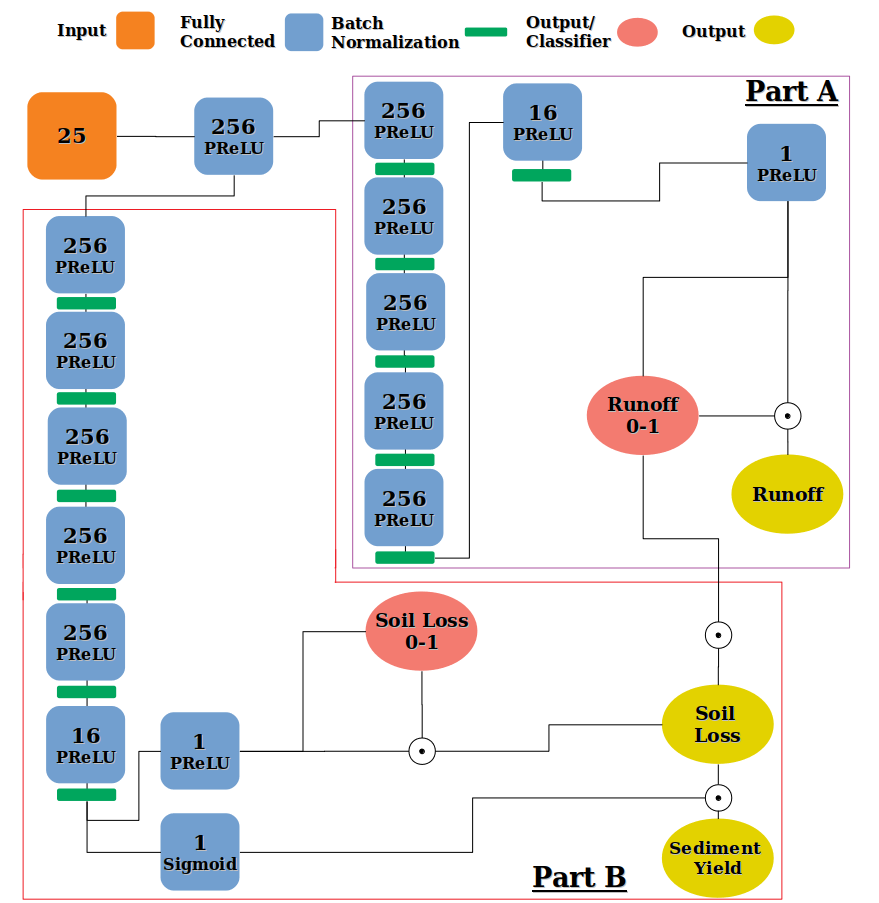

In [5]:
trainableParams = np.sum([np.prod(v.get_shape()) for v in RHEM_emulator().trainable_weights])
nonTrainableParams = np.sum([np.prod(v.get_shape()) for v in RHEM_emulator().non_trainable_weights])
totalParams = trainableParams + nonTrainableParams
 
print('Total Trainable Parameters:', f'{trainableParams:,}')
print('Total non-Trainable Parameters:', f'{nonTrainableParams:,}')
print('Total Parameters:', f'{totalParams:,}')

from IPython.display import Image
Image(filename='emulator.png', width=500, height=300) 

### Import the synthetic RHEM scenarios along with their RHEM outputs (Section 3 of the paper)

Here we import a table named dataset.csv which has 1,035,331 RHEM scenarios and their corresponding RHEM runs (see section 3 of the paper for more details)

In [6]:
dataset = pd.read_csv('Files/Data/dataset.csv')
dataset

,SL1,SL2,G,DIST,POR,SMAX,FRACT1,FRACT2,FRACT3,FRACT4,...,Forbs,Shrubs,SodGrass,totalFoliar,prcp,dur,tp,ip,runoff_bool,soilLoss_bool
0,0.001000,0.564450,375,0.15,0.4704,0.88,0.1196,0.1517,0.3244,0.4012,...,0.458975,52.116188,6.443537,84.127635,20.594088,7.820512,0.189141,4.736799,1,1
1,0.001000,0.924819,260,0.32,0.4377,0.83,0.0641,0.0005,0.1686,0.6217,...,0.003754,12.779875,5.943892,19.357070,16.548742,2.808490,0.254343,5.326109,1,1
2,0.832437,0.832437,200,0.23,0.4455,0.97,0.0505,0.3095,0.3497,0.2255,...,4.374951,21.315620,13.465923,84.309376,12.789411,7.883860,0.114685,3.428492,1,1
3,0.446814,0.001000,260,0.24,0.4589,0.84,0.0848,0.0397,0.3157,0.5148,...,25.051810,3.850625,23.026242,97.198250,5.029604,4.417209,0.181971,3.366415,1,1
4,0.001000,0.666196,260,0.32,0.4377,0.83,0.0641,0.0005,0.1686,0.6217,...,0.056828,0.000245,0.520086,0.666904,15.440207,14.577748,0.088328,2.935793,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1035326,0.434712,0.434712,130,0.38,0.4306,0.91,0.0325,0.0542,0.1801,0.3939,...,55.064687,14.499359,0.527966,71.666969,18.709548,13.193460,0.129313,4.037549,1,1
1035327,0.018563,0.001000,350,0.18,0.4581,0.92,0.0861,0.1986,0.4014,0.3044,...,1.336506,4.725737,61.784712,81.665417,10.203109,7.428898,0.178775,4.218257,1,1
1035328,0.001000,0.678330,260,0.24,0.4589,0.84,0.0848,0.0397,0.3157,0.5148,...,0.086411,5.025984,0.927194,6.859493,10.610177,6.685763,0.150877,3.707578,1,1
1035329,0.833627,0.833627,305,0.22,0.4146,0.75,0.1073,0.0001,0.1039,0.7544,...,25.318198,29.535822,1.236467,66.676850,18.709548,13.193460,0.129313,4.037549,1,1


Here we define the inputs and outputs of the Emulator to train it. We scale the Ground and Foliar covers percentages to [0,1] range.

In [7]:
## define the inputs and outputs of the model
X = dataset.loc[:, ['prcp', 'dur', 'tp', 'ip',
                   'SL1', 'SL2', 'G', 'DIST', 'POR', 'SMAX',
                   'FRACT1', 'FRACT2', 'FRACT3', 'FRACT4', 'FRACT5',
                   'Litter', 'BiologicalCrusts', 'Basal',
                   'Rock', 'totalGround', 'Forbs',
                   'BunchGrass', 'Shrubs', 'SodGrass',
                   'totalFoliar']].values
X[:,15:] = X[:,15:]/100

Y = dataset.loc[:, ['runoff_bool', 'soilLoss_bool', 'runoff', 'soilLoss', 'sedYield']].values

### Train the Emulator (Section 2.7 of the paper)

Now that we have the required dataset, it is time to train the Emulator. To better evaluate the model, we first set up a cross validation process. We divide the 1,035,331 scenarios into 10 folds. Then within a loop we take out one of the folds and train the model by the remaining scenarios. we test the model performance by the out-of-sample fold. The model performance metrics are NSE, alpha and beta (see section 2.3 for more details)

In [11]:
## 10-Fold cross validation
kf = KFold(n_splits=10)

## save the prediction and observation values of the 10 testing phase in the following lists
predict_runOff = []
observed_runOff = []

predict_soilLoss = []
observed_soilLoss = []

predict_sedYield = []
observed_sedYield = []

predict_runOff_mul = []
observed_runOff_mul = []

predict_soilLoss_mul = []
observed_soilLoss_mul = [] 


## define and learning rate scheduler (see section 2.7 for more details)
initial = 0.001
a = 0.5
b = 50
def scheduler(epoch):
    return initial * np.power(a, np.floor((1+epoch)/b))

callback3 = tf.keras.callbacks.LearningRateScheduler(scheduler)

## The 10-fold cross validation loop
for train_index, test_index in kf.split(X):
    ## define train and the out-of-sample test sets
    x_train = X[train_index]
    y_train = Y[train_index]
    
    x_test = X[test_index]
    y_test = Y[test_index]
    
    ## perform the normalization on each training data seperately to avoid the data leak

    # min-max normalization on 'prcp', 'dur', 'ip', 'G'
    minmaxt_x = MinMaxScaler((0.001, 1))
    minmaxt_x.fit(x_train[:,[0,1,3,6]])
    x_train[:,[0,1,3,6]] = minmaxt_x.transform(x_train[:,[0,1,3,6]])
    x_test[:,[0,1,3,6]] = minmaxt_x.transform(x_test[:,[0,1,3,6]])
    
    # log transform and normalization of the runoff, soil loss and sediment yield
    runoff_zero = np.where(y_train[:,2] == 0.)
    soliLoss_zero = np.where(y_train[:,3] == 0.)
    sedYield_zero = np.where(y_train[:,4] == 0.)

    soliLoss_nonzero = np.where(y_train[:,3] != 0.)

    y_train[:,2] = np.where(y_train[:,2]==0, 0, np.log(y_train[:,2]))
    y_train[:,3] = np.where(y_train[:,3]==0, 0, np.log(y_train[:,3]))
    y_train[:,4] = np.where(y_train[:,4]==0, 0, np.log(y_train[:,4]))

    minmaxt_y_runoff = MinMaxScaler((0.001,1))
    minmaxt_y_runoff.fit(y_train[:,[2]][np.where(y_train[:,0]!=0)])
    minmaxt_y_erosion = MinMaxScaler((0.001,1))
    minmaxt_y_erosion.fit(y_train[:,[3]][soliLoss_nonzero])

    y_train[:,[2]] = minmaxt_y_runoff.transform(y_train[:,[2]])
    y_train[:,[3]] = minmaxt_y_erosion.transform(y_train[:,[3]])
    y_train[:,[4]] = minmaxt_y_erosion.transform(y_train[:,[4]])
    y_train[runoff_zero,[2]] = 0.
    y_train[soliLoss_zero,[3]] = 0.
    y_train[sedYield_zero,[4]] = 0.
    
    ## train the model
    
    # specify the weights of the weighted_binary_crossentropy() loss functions
    w0_runoff,w1_runoff = y_train[:,0].size/(np.bincount(y_train[:,0].astype(int)))
    w0_soilLoss,w1_soilLoss = y_train[:,1].size/(np.bincount(y_train[:,1].astype(int)))
    
    # start training (batch size: 1000, epochs: 300)
    start_time = time.time()
    emulator = RHEM_emulator(w0_runoff,w1_runoff,w0_soilLoss,w1_soilLoss)
    emulator.fit(x_train, [y_train[:,0:1].astype(int), y_train[:,1:2].astype(int), y_train[:,2:3], y_train[:,3:4], y_train[:,4:]], epochs = 300, 
                                  batch_size=1000, validation_split=0.1, callbacks=[callback3], verbose=0)
    
    print("Training time: --- %s seconds ---" % (time.time() - start_time))
    
    ## make a prediction on the out-of-sample test set
    start_time = time.time()
    predicted = emulator.predict(tf.convert_to_tensor(x_test))
    print("Prediction time: --- %s seconds ---" % (time.time() - start_time))
    predicted = np.squeeze(np.array(predicted), axis=2).T

    predicted[:,2:3] = minmaxt_y_runoff.inverse_transform(predicted[:,2:3])
    predicted[:,3:4] = minmaxt_y_erosion.inverse_transform(predicted[:,3:4])
    predicted[:,4:] = minmaxt_y_erosion.inverse_transform(predicted[:,4:])

    predicted[:,2:3] = np.exp(predicted[:,2:3])
    predicted[:,3:] = np.exp(predicted[:,3:])

    predicted[:, 2] = predicted[:, 2] * predicted[:, 0]
    predicted[:, 3] = predicted[:, 3] * predicted[:, 1]
    predicted[:, 4] = predicted[:, 4] * predicted[:, 1]
    
    ## Print the model performance
    
    # Calculate the NSE, alpha and beta measures
    pred_run = predicted[:,2].tolist()
    obs_run = y_test[:,2].tolist()
    print('runoff_NSE:',np.round(r2_score(obs_run, pred_run), 3))
    print('runoff_alpha:',np.round(np.std(pred_run)/np.std(obs_run), 3))
    print('runoff_beta:',np.round((np.mean(pred_run) - np.mean(obs_run))/np.std(obs_run), 3))

    predict_runOff.extend(pred_run)
    observed_runOff.extend(obs_run)
    
    pred_soil = predicted[:,3].tolist()
    obs_soil = y_test[:,3].tolist()
    print('soilLoss_NSE:',np.round(r2_score(obs_soil, pred_soil), 3))
    print('soilLoss_alpha:',np.round(np.std(pred_soil)/np.std(obs_soil), 3))
    print('soilLoss_beta:',np.round((np.mean(pred_soil) - np.mean(obs_soil))/np.std(obs_soil), 3))
    
    predict_soilLoss.extend(pred_soil)
    observed_soilLoss.extend(obs_soil)
    
    pred_sed = predicted[:,4].tolist()
    obs_sed = y_test[:,4].tolist()
    print('sediment_NSE:',np.round(r2_score(obs_sed, pred_sed), 3))
    print('sediment_alpha:',np.round(np.std(pred_sed)/np.std(obs_sed), 3))
    print('sediment_beta:',np.round((np.mean(pred_sed) - np.mean(obs_sed))/np.std(obs_sed), 3))
    
    predict_sedYield.extend(pred_sed)
    observed_sedYield.extend(obs_sed)
    
    predict_runOff_mul.extend(predicted[:, 0].tolist())
    observed_runOff_mul.extend(y_test[:,0].tolist())
    
    predict_soilLoss_mul.extend(predicted[:, 1].tolist())
    observed_soilLoss_mul.extend(y_test[:,1].tolist())
    
    # The confusion matrix of the runoff and the soil loss classifiers 
    print('Confusion Matrix of the runoff classifier')
    print(confusion_matrix(y_test[:,0], predicted[:, 0]))
    
    print('Confusion Matrix of the soil loss classifier')
    print(confusion_matrix(y_test[:,1], predicted[:, 1]))
    
    print('________________________')

/home/kia/anaconda3/envs/rhem/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: divide by zero encountered in log
/home/kia/anaconda3/envs/rhem/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in log
/home/kia/anaconda3/envs/rhem/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in log


Training time: --- 1369.2038934230804 seconds ---
Prediction time: --- 3.685249090194702 seconds ---
runoff_NSE: 1.0
runoff_alpha: 0.991
runoff_beta: -0.007
soilLoss_NSE: 0.999
soilLoss_alpha: 0.992
soilLoss_beta: -0.001
sediment_NSE: 0.999
sediment_alpha: 0.99
sediment_beta: -0.001
Confusion Matrix of the runoff classifier
[[  2016     36]
 [    73 101409]]
Confusion Matrix of the soil loss classifier
[[ 1662     1]
 [ 2055 99816]]
________________________


/home/kia/anaconda3/envs/rhem/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: divide by zero encountered in log
/home/kia/anaconda3/envs/rhem/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in log
/home/kia/anaconda3/envs/rhem/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in log


Training time: --- 1383.929703950882 seconds ---
Prediction time: --- 3.694007635116577 seconds ---
runoff_NSE: 1.0
runoff_alpha: 1.004
runoff_beta: 0.003
soilLoss_NSE: 0.999
soilLoss_alpha: 0.997
soilLoss_beta: -0.0
sediment_NSE: 0.999
sediment_alpha: 0.996
sediment_beta: -0.0
Confusion Matrix of the runoff classifier
[[  2088     24]
 [    71 101350]]
Confusion Matrix of the soil loss classifier
[[ 1675     0]
 [ 2102 99756]]
________________________


/home/kia/anaconda3/envs/rhem/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: divide by zero encountered in log
/home/kia/anaconda3/envs/rhem/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in log
/home/kia/anaconda3/envs/rhem/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in log


Training time: --- 1355.8820397853851 seconds ---
Prediction time: --- 3.5592291355133057 seconds ---
runoff_NSE: 1.0
runoff_alpha: 0.994
runoff_beta: -0.005
soilLoss_NSE: 0.999
soilLoss_alpha: 1.001
soilLoss_beta: 0.0
sediment_NSE: 0.999
sediment_alpha: 1.001
sediment_beta: 0.0
Confusion Matrix of the runoff classifier
[[  2129     24]
 [    62 101318]]
Confusion Matrix of the soil loss classifier
[[ 1638     1]
 [ 2115 99779]]
________________________


/home/kia/anaconda3/envs/rhem/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: divide by zero encountered in log
/home/kia/anaconda3/envs/rhem/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in log
/home/kia/anaconda3/envs/rhem/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in log


Training time: --- 1357.0508768558502 seconds ---
Prediction time: --- 3.6758053302764893 seconds ---
runoff_NSE: 1.0
runoff_alpha: 0.996
runoff_beta: -0.001
soilLoss_NSE: 0.999
soilLoss_alpha: 0.995
soilLoss_beta: -0.001
sediment_NSE: 0.999
sediment_alpha: 0.995
sediment_beta: -0.0
Confusion Matrix of the runoff classifier
[[  2169     33]
 [    65 101266]]
Confusion Matrix of the soil loss classifier
[[ 1616     3]
 [ 2191 99723]]
________________________


/home/kia/anaconda3/envs/rhem/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: divide by zero encountered in log
/home/kia/anaconda3/envs/rhem/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in log
/home/kia/anaconda3/envs/rhem/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in log


Training time: --- 1348.892460823059 seconds ---
Prediction time: --- 3.6805784702301025 seconds ---
runoff_NSE: 1.0
runoff_alpha: 1.002
runoff_beta: 0.002
soilLoss_NSE: 0.999
soilLoss_alpha: 0.997
soilLoss_beta: -0.001
sediment_NSE: 0.999
sediment_alpha: 0.996
sediment_beta: -0.001
Confusion Matrix of the runoff classifier
[[  2119     32]
 [    59 101323]]
Confusion Matrix of the soil loss classifier
[[ 1721     2]
 [ 2130 99680]]
________________________


/home/kia/anaconda3/envs/rhem/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: divide by zero encountered in log
/home/kia/anaconda3/envs/rhem/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in log
/home/kia/anaconda3/envs/rhem/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in log


Training time: --- 1334.146689414978 seconds ---
Prediction time: --- 3.5283284187316895 seconds ---
runoff_NSE: 1.0
runoff_alpha: 0.992
runoff_beta: -0.006
soilLoss_NSE: 0.999
soilLoss_alpha: 0.999
soilLoss_beta: 0.0
sediment_NSE: 0.999
sediment_alpha: 0.998
sediment_beta: 0.0
Confusion Matrix of the runoff classifier
[[  2270     35]
 [    71 101157]]
Confusion Matrix of the soil loss classifier
[[ 1633     0]
 [ 2285 99615]]
________________________


/home/kia/anaconda3/envs/rhem/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: divide by zero encountered in log
/home/kia/anaconda3/envs/rhem/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in log
/home/kia/anaconda3/envs/rhem/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in log


Training time: --- 1349.2735843658447 seconds ---
Prediction time: --- 3.5759029388427734 seconds ---
runoff_NSE: 1.0
runoff_alpha: 1.004
runoff_beta: 0.005
soilLoss_NSE: 0.999
soilLoss_alpha: 0.998
soilLoss_beta: -0.001
sediment_NSE: 0.999
sediment_alpha: 0.996
sediment_beta: -0.001
Confusion Matrix of the runoff classifier
[[  2061     44]
 [    60 101368]]
Confusion Matrix of the soil loss classifier
[[ 1653     3]
 [ 2093 99784]]
________________________


/home/kia/anaconda3/envs/rhem/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: divide by zero encountered in log
/home/kia/anaconda3/envs/rhem/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in log
/home/kia/anaconda3/envs/rhem/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in log


Training time: --- 1341.505413532257 seconds ---
Prediction time: --- 3.6034862995147705 seconds ---
runoff_NSE: 1.0
runoff_alpha: 1.0
runoff_beta: 0.002
soilLoss_NSE: 0.999
soilLoss_alpha: 1.007
soilLoss_beta: 0.001
sediment_NSE: 0.999
sediment_alpha: 1.008
sediment_beta: 0.001
Confusion Matrix of the runoff classifier
[[  2108     28]
 [    68 101329]]
Confusion Matrix of the soil loss classifier
[[ 1639     3]
 [ 2124 99767]]
________________________


/home/kia/anaconda3/envs/rhem/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: divide by zero encountered in log
/home/kia/anaconda3/envs/rhem/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in log
/home/kia/anaconda3/envs/rhem/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in log


Training time: --- 1364.2302482128143 seconds ---
Prediction time: --- 3.8885374069213867 seconds ---
runoff_NSE: 1.0
runoff_alpha: 1.0
runoff_beta: -0.003
soilLoss_NSE: 0.998
soilLoss_alpha: 1.008
soilLoss_beta: 0.001
sediment_NSE: 0.998
sediment_alpha: 1.007
sediment_beta: 0.001
Confusion Matrix of the runoff classifier
[[  2014     32]
 [    51 101436]]
Confusion Matrix of the soil loss classifier
[[ 1678     1]
 [ 2050 99804]]
________________________


/home/kia/anaconda3/envs/rhem/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: divide by zero encountered in log
/home/kia/anaconda3/envs/rhem/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in log
/home/kia/anaconda3/envs/rhem/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in log


Training time: --- 1355.4318656921387 seconds ---
Prediction time: --- 3.6073665618896484 seconds ---
runoff_NSE: 1.0
runoff_alpha: 0.997
runoff_beta: -0.001
soilLoss_NSE: 0.999
soilLoss_alpha: 0.996
soilLoss_beta: -0.001
sediment_NSE: 0.999
sediment_alpha: 0.995
sediment_beta: -0.0
Confusion Matrix of the runoff classifier
[[  2108     31]
 [    74 101320]]
Confusion Matrix of the soil loss classifier
[[ 1697     0]
 [ 2136 99700]]
________________________


### The Accuracy of the runoff, soil loss and sediment yield predictions of the Emulator (Section 4.3 of the paper, Figure 3)
Here we visualize the scatterplots of the RHEM runs vs. Emulator runs of the synthetic scenarios for the runoff, soil loss and sediment yield. The Emulator runs are from the out-of-sample testing of the cross validation loop. 

We have prepared and saved the cross validation results. If you have not run the cross validation yourself and just want to see the model evaluations run the cell below. Otherwise ignore it and go to the next cell:

In [13]:
with open('Files/Cross-Validation_Results/predict_runOff.pkl', 'rb') as file:
    predict_runOff = pickle.load(file)
with open('Files/Cross-Validation_Results/observed_runOff.pkl', 'rb') as file:
    observed_runOff = pickle.load(file)
    
with open('Files/Cross-Validation_Results/predict_soilLoss.pkl', 'rb') as file:
    predict_soilLoss = pickle.load(file)
with open('Files/Cross-Validation_Results/observed_soilLoss.pkl', 'rb') as file:
    observed_soilLoss = pickle.load(file)

with open('Files/Cross-Validation_Results/predict_sedYield.pkl', 'rb') as file:
    predict_sedYield = pickle.load(file)
with open('Files/Cross-Validation_Results/observed_sedYield.pkl', 'rb') as file:
    observed_sedYield = pickle.load(file)
    
with open('Files/Cross-Validation_Results/predict_runOff_mul.pkl', 'rb') as file:
    predict_runOff_mul = pickle.load(file)
with open('Files/Cross-Validation_Results/observed_runOff_mul.pkl', 'rb') as file:
    observed_runOff_mul = pickle.load(file)
    
with open('Files/Cross-Validation_Results/predict_soilLoss_mul.pkl', 'rb') as file:
    predict_soilLoss_mul = pickle.load(file)
with open('Files/Cross-Validation_Results/observed_soilLoss_mul.pkl', 'rb') as file:
    observed_soilLoss_mul = pickle.load(file)

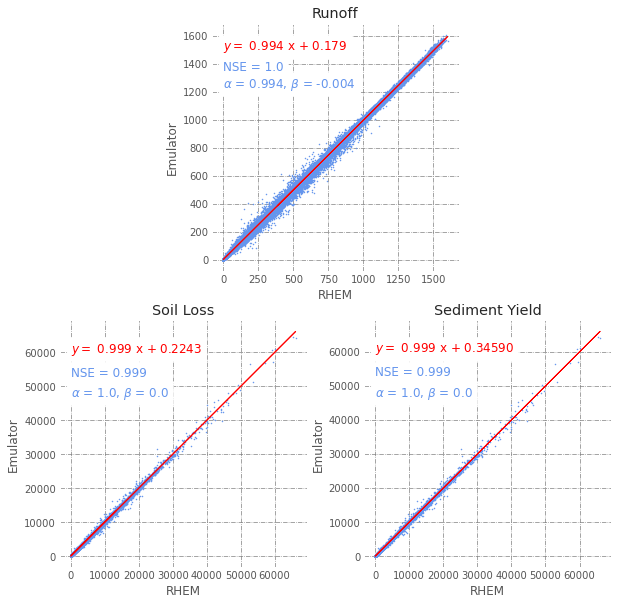

In [14]:
plt.style.use('ggplot')
plt.rcParams['axes.facecolor']='white'
np.set_printoptions(suppress=True)

slope, intercept, r_value, p_value, std_err = linregress(observed_runOff, predict_runOff)
r_squared_runOff = r2_score(observed_runOff, predict_runOff)
alpha_runoff = np.std(predict_runOff)/np.std(observed_runOff)
beta_runoff = (np.mean(predict_runOff) - np.mean(observed_runOff))/np.std(observed_runOff)

slope1, intercept1, r_value1, p_value1, std_err1 = linregress(observed_soilLoss, predict_soilLoss)
r_squared_soil = r2_score(observed_soilLoss, predict_soilLoss)
alpha_soilLoss = np.std(predict_soilLoss)/np.std(observed_soilLoss)
beta_soilLoss = (np.mean(predict_soilLoss) - np.mean(observed_soilLoss))/np.std(observed_soilLoss)

slope2, intercept2, r_value2, p_value2, std_err2 = linregress(observed_sedYield, predict_sedYield)
r_squared_sedYield = r2_score(observed_sedYield, predict_sedYield)
alpha_sedYield = np.std(predict_sedYield)/np.std(observed_sedYield)
beta_sedYield = (np.mean(predict_sedYield) - np.mean(observed_sedYield))/np.std(observed_sedYield)

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Helvetica'

font = {'size'   : 14}

fig = plt.figure(figsize=(10,10))
gs = gridspec.GridSpec(2, 4, figure=fig)
ax1 = fig.add_subplot(gs[0, 1:3], aspect='equal')
ax2 = fig.add_subplot(gs[1, :2], aspect='equal')
ax3 = fig.add_subplot(gs[1, 2:], aspect='equal')

ax1.grid(color='gray', linestyle='-.', linewidth=0.7)
ax1.plot(np.asarray(observed_runOff), slope*np.asarray(observed_runOff) + intercept, color='red', linewidth=1)
ax1.scatter(observed_runOff, predict_runOff, color='cornflowerblue', s=1, rasterized=True)
ax1.text(0.05, 1500, r'$y = $ {} x $ + $ {}'.format(np.round(slope,3), np.round(intercept,3)), color='red', fontsize=12, bbox=dict(facecolor='white', edgecolor='white'))
ax1.text(0.05, 1350, r'NSE = {}'.format(np.round(r_squared_runOff,3)), color='cornflowerblue', fontsize=12, bbox=dict(facecolor='white', edgecolor='white'))
ax1.text(0.05, 1230, r'$\alpha$ = {}, $\beta$ = {}'.format(np.round(alpha_runoff,3), np.round(beta_runoff,3)), color='cornflowerblue', fontsize=12, bbox=dict(facecolor='white', edgecolor='white'))
ax1.set_title('Runoff')
ax1.set_xlabel('RHEM')
ax1.set_ylabel('Emulator')

ax2.grid(color='gray', linestyle='-.', linewidth=0.7)
ax2.plot(np.asarray(observed_soilLoss), slope1*np.asarray(observed_soilLoss) + intercept1, color='red', linewidth=1)
ax2.scatter(observed_soilLoss, predict_soilLoss, color='cornflowerblue', s=1, rasterized=True)
ax2.text(0.05, 60000, r'$y = $ {} x $ + $ {}'.format(np.round(slope1,3), np.round(intercept1,4)), color='red', fontsize=12, bbox=dict(facecolor='white', edgecolor='white'))
ax2.text(0.05, 53000, r'NSE = {}'.format(np.round(r_squared_soil,3)), color='cornflowerblue', fontsize=12, bbox=dict(facecolor='white', edgecolor='white'))
ax2.text(0.05, 47000, r'$\alpha$ = {}, $\beta$ = {}'.format(np.round(alpha_soilLoss,3), np.round(beta_soilLoss,3)), color='cornflowerblue', fontsize=12, bbox=dict(facecolor='white', edgecolor='white'))
ax2.set_title('Soil Loss')
ax2.set_xlabel('RHEM')
ax2.set_ylabel('Emulator')

ax3.grid(color='gray', linestyle='-.', linewidth=0.7)
ax3.plot(np.asarray(observed_sedYield), slope1*np.asarray(observed_sedYield) + intercept2, color='red', linewidth=1)
ax3.scatter(observed_sedYield, predict_sedYield, color='cornflowerblue', s=1, rasterized=True)
ax3.text(0.05, 60000, r'$y = $ {} x $ + $ {}'.format(np.round(slope2,3), f"{intercept2:.5f}"), color='red', fontsize=12, bbox=dict(facecolor='white', edgecolor='white'))
ax3.text(0.05, 53000, r'NSE = {}'.format(np.round(r_squared_sedYield,3)), color='cornflowerblue', fontsize=12, bbox=dict(facecolor='white', edgecolor='white'))
ax3.text(0.05, 47000, r'$\alpha$ = {}, $\beta$ = {}'.format(np.round(alpha_sedYield,3), np.round(beta_sedYield,3)), color='cornflowerblue', fontsize=12, bbox=dict(facecolor='white', edgecolor='white'))
ax3.set_title('Sediment Yield')
ax3.set_xlabel('RHEM')
ax3.set_ylabel('Emulator')

plt.subplots_adjust(hspace=0.2,
                    wspace=0.5)


### Accuracy metrics of the classifiers (Section 4.3 of the paper)
Run the cells below to explore the accuracies of the runoff and soil loss classifiers of the Emulator. It prints the precision, recall and f1-score metrics. It also gives the average values of the runoff and soil loss outputs when the classifiers are wrong.

In [15]:
print('Accuracy metrics for the Runoff classifier:')
print(classification_report(observed_runOff_mul, predict_runOff_mul))


falseZeroPred = np.where((np.array(predict_runOff_mul) == 0) & (np.array(observed_runOff_mul) != 0))
print('The average runoff values of the cases that the runoff classifier incorrectly predicted zero:')
print(np.round(np.mean(np.array(observed_runOff)[falseZeroPred]), 6))

falseZeroPred = np.where((np.array(predict_runOff_mul) == 1) & (np.array(observed_runOff_mul) != 1))
print('The average predicted runoff values of the cases that the classifier incorrectly predicted non-zero:')
print(np.round(np.mean(np.array(predict_runOff)[falseZeroPred]), 6))

Accuracy metrics for the Runoff classifier:
              precision    recall  f1-score   support

         0.0       0.97      0.99      0.98     21401
         1.0       1.00      1.00      1.00   1013930

    accuracy                           1.00   1035331
   macro avg       0.99      0.99      0.99   1035331
weighted avg       1.00      1.00      1.00   1035331

The average runoff values of the cases that the runoff classifier incorrectly predicted zero:
6e-06
The average predicted runoff values of the cases that the classifier incorrectly predicted non-zero:
1.7e-05


In [16]:
print('Accuracy metrics for the Soil loss classifier:')
print(classification_report(observed_soilLoss_mul, predict_soilLoss_mul))

falseZeroPred = np.where((np.array(predict_soilLoss_mul) == 1) & (np.array(observed_soilLoss_mul) != 1))
print('The average predicted soil loss values of the cases that the classifier incorrectly predicted non-zero:')
print(np.round(np.mean(np.array(predict_soilLoss)[falseZeroPred]), 8))

falseZeroPred = np.where((np.array(predict_soilLoss_mul) == 0) & (np.array(observed_soilLoss_mul) != 0))
print('The average soil loss values in the cases where the classifier incorrectly predicted zero:')
print(np.round(np.mean(np.array(observed_runOff)[falseZeroPred]), 8))

Accuracy metrics for the Soil loss classifier:
              precision    recall  f1-score   support

         0.0       0.44      1.00      0.61     16626
         1.0       1.00      0.98      0.99   1018705

    accuracy                           0.98   1035331
   macro avg       0.72      0.99      0.80   1035331
weighted avg       0.99      0.98      0.98   1035331

The average predicted soil loss values of the cases that the classifier incorrectly predicted non-zero:
3.59e-06
The average soil loss values in the cases where the classifier incorrectly predicted zero:
1.576e-05


### Train the Emulator by the entire synthetic dataset

After model evaluation in a cross-validation process, we can train the model by the entire synthetic scenarios. Run the cell below to train the Emulator.

In [17]:
x_train = X.copy()
y_train = Y.copy()

# min-max normalization on 'prcp', 'dur', 'ip', 'G'
minmaxt_x = MinMaxScaler((0.001, 1))
minmaxt_x.fit(x_train[:,[0,1,3,6]])
x_train[:,[0,1,3,6]] = minmaxt_x.transform(x_train[:,[0,1,3,6]])

# log transform and normalization of the runoff, soil loss and sediment yield
runoff_zero = np.where(y_train[:,2] == 0.)
soliLoss_zero = np.where(y_train[:,3] == 0.)
sedYield_zero = np.where(y_train[:,4] == 0.)

soliLoss_nonzero = np.where(y_train[:,3] != 0.)

y_train[:,2] = np.where(y_train[:,2]==0, 0, np.log(y_train[:,2]))
y_train[:,3] = np.where(y_train[:,3]==0, 0, np.log(y_train[:,3]))
y_train[:,4] = np.where(y_train[:,4]==0, 0, np.log(y_train[:,4]))

minmaxt_y_runoff = MinMaxScaler((0.001,1))
minmaxt_y_runoff.fit(y_train[:,[2]][np.where(y_train[:,0]!=0)])
minmaxt_y_erosion = MinMaxScaler((0.001,1))
minmaxt_y_erosion.fit(y_train[:,[3]][soliLoss_nonzero])

y_train[:,[2]] = minmaxt_y_runoff.transform(y_train[:,[2]])
y_train[:,[3]] = minmaxt_y_erosion.transform(y_train[:,[3]])
y_train[:,[4]] = minmaxt_y_erosion.transform(y_train[:,[4]])
y_train[runoff_zero,[2]] = 0.
y_train[soliLoss_zero,[3]] = 0.
y_train[sedYield_zero,[4]] = 0.


## Define the learning rate scheduler
initial = 0.001
a = 0.5
b = 50
def scheduler(epoch):
    return initial * np.power(a, np.floor((1+epoch)/b))

callback3 = tf.keras.callbacks.LearningRateScheduler(scheduler)

##############
# Here, you may create a Tensorboard callback to save the training loss. Then, add it to the callbacks argument
# of the emulator.fit() function below.
##############

# specify the weights of the weighted_binary_crossentropy() loss functions
w0_runoff,w1_runoff = y_train[:,0].size/(np.bincount(y_train[:,0].astype(int)))
w0_soilLoss,w1_soilLoss = y_train[:,1].size/(np.bincount(y_train[:,1].astype(int)))

# Initialize and train the model (epoch:300, batch-size=1000)
print('Initialize the model')
emulator = RHEM_emulator(w0_runoff,w1_runoff,w0_soilLoss,w1_soilLoss)
print('Training...')
emulator.fit(x_train, [y_train[:,0:1].astype(int), y_train[:,1:2].astype(int), y_train[:,2:3], y_train[:,3:4], y_train[:,4:]], 
             epochs = 300, batch_size=1000, callbacks=[callback3], verbose=0)
print('Done')

/home/kia/anaconda3/envs/rhem/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()
/home/kia/anaconda3/envs/rhem/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log
/home/kia/anaconda3/envs/rhem/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in log


Initialize the model
Training...
Done


### The training loss plot (Figure 2 of the paper)
During the model training by the entire synthetic scenarios, we have saved the loss values after each epoch using the <a href="https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/TensorBoard">Tensorboard callback</a> and prepared them for plotting. You may also use the same callback in the training process of the cell above to make your own loss value tables. Run the cell below to visualize the training loss values of the model outputs after each epoch.

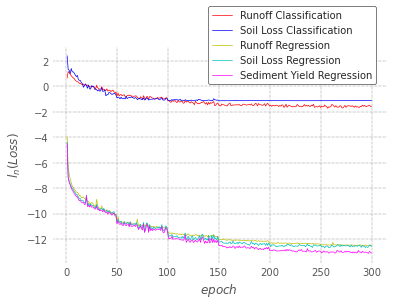

In [18]:
plt.style.use('ggplot')
plt.rcParams['axes.facecolor']='white'
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Helvetica'

font = {'size'   : 14}

runoff_class_loss = pd.read_csv('Files/Training_loss/runoff_mul_loss.csv').iloc[:,1:]
runoff_regress_loss = pd.read_csv('Files/Training_loss/runoff_loss.csv').iloc[:,1:]
soilLoss_class_loss = pd.read_csv('Files/Training_loss/soilLoss_mul_loss.csv').iloc[:,1:]
soilLoss_regress_loss = pd.read_csv('Files/Training_loss/soilLoss_loss.csv').iloc[:,1:]
sediment_regress_loss = pd.read_csv('Files/Training_loss/sedYield_loss.csv').iloc[:,1:]

plt.grid(color='gray', linestyle='-.', linewidth=0.4)
plt.plot(runoff_class_loss.Step+1, np.log(runoff_class_loss.Value), color='r', linewidth=0.7, label='Runoff Classification')
plt.plot(soilLoss_class_loss.Step+1, np.log(soilLoss_class_loss.Value), color='b', linewidth=0.7, label='Soil Loss Classification')
plt.plot(runoff_regress_loss.Step+1, np.log(runoff_regress_loss.Value), color='y', linewidth=0.7, label='Runoff Regression')
plt.plot(soilLoss_regress_loss.Step+1, np.log(soilLoss_regress_loss.Value), color='c', linewidth=0.7, label='Soil Loss Regression')
plt.plot(sediment_regress_loss.Step+1, np.log(sediment_regress_loss.Value), color='magenta', linewidth=0.7, label='Sediment Yield Regression')

plt.ylabel(r'$l_n (Loss)$')
plt.xlabel(r'$epoch$')
legend = plt.legend(frameon = 1,bbox_to_anchor=(0.45, 0.8), loc=3)
frame = legend.get_frame()
frame.set_facecolor('white')
frame.set_edgecolor('black')
frame.set_alpha(None)


### Evaluate the trained Emulator with the real world scenarios (Figure 4.a of the paper)

To see how accurate the trained Emulator is for the real-world scenarios, here, we test the model with the NRI scenarios (see section 3 of the paper). 

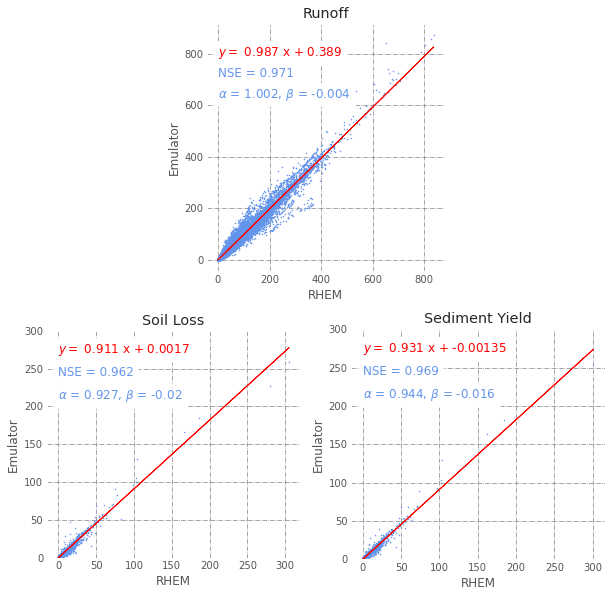

In [21]:
# Read and shuffle the NRI dataset
testNRI = pd.read_csv('Files/Data/NRI_dataset.csv')
testNRI = testNRI.sample(n=len(testNRI.index))

## create the boolean runoff field
testNRI['runoff_bool'] = np.where(testNRI['runoff'] == 0,0,1)
testNRI['soilLoss_bool'] = np.where((testNRI['soilLoss'] == 0) & (testNRI['runoff'] != 0),0,1)


## define the inputs and outputs of the model
X_testNRI = testNRI.loc[:, ['prcp', 'dur', 'tp', 'ip',
                   'SL1', 'SL2', 'G', 'DIST', 'POR', 'SMAX',
                   'FRACT1', 'FRACT2', 'FRACT3', 'FRACT4', 'FRACT5',
                   'Litter', 'BiologicalCrusts', 'Basal',
                   'Rock', 'totalGround', 'Forbs',
                   'BunchGrass', 'Shrubs', 'SodGrass',
                   'totalFoliar']].values
Y_testNRI = testNRI.loc[:, ['runoff_bool','soilLoss_bool', 'runoff', 'soilLoss', 'sedYield']].values

## normalize the NRI's input using the normalizer that has been fit to the synthetic scenarios 
X_testNRI[:,[0,1,3,6]] = minmaxt_x.transform(X_testNRI[:,[0,1,3,6]])
X_testNRI[:,15:] = X_testNRI[:,15:]/100

## predict the NRI outputs by the emulator
predicted = emulator.predict(tf.convert_to_tensor(X_testNRI))
predicted = np.squeeze(np.array(predicted), axis=2).T


predicted[:,2:3] = minmaxt_y_runoff.inverse_transform(predicted[:,2:3])
predicted[:,3:4] = minmaxt_y_erosion.inverse_transform(predicted[:,3:4])
predicted[:,4:] = minmaxt_y_erosion.inverse_transform(predicted[:,4:])

predicted[:,2:3] = np.exp(predicted[:,2:3])
predicted[:,3:] = np.exp(predicted[:,3:])

predicted[:, 2] = predicted[:, 2] * predicted[:, 0]
predicted[:, 3] = predicted[:, 3] * predicted[:, 1]
predicted[:, 4] = predicted[:, 4] * predicted[:, 1]

predict_runOff = predicted[:,2].tolist()
observed_runOff = Y_testNRI[:,2].tolist()
slope, intercept, r_value, p_value, std_err = linregress(observed_runOff, predict_runOff)
r_squared_runOff = r2_score(observed_runOff, predict_runOff)
alpha_runoff = np.std(predict_runOff)/np.std(observed_runOff)
beta_runoff = (np.mean(predict_runOff) - np.mean(observed_runOff))/np.std(observed_runOff)

predict_soilLoss = predicted[:,3].tolist()
observed_soilLoss = Y_testNRI[:,3].tolist()
slope1, intercept1, r_value1, p_value1, std_err1 = linregress(observed_soilLoss, predict_soilLoss)
r_squared_soil = r2_score(observed_soilLoss, predict_soilLoss)
alpha_soilLoss = np.std(predict_soilLoss)/np.std(observed_soilLoss)
beta_soilLoss = (np.mean(predict_soilLoss) - np.mean(observed_soilLoss))/np.std(observed_soilLoss)

predict_sedYield = predicted[:,4].tolist()
observed_sedYield = Y_testNRI[:,4].tolist()
slope2, intercept2, r_value2, p_value2, std_err2 = linregress(observed_sedYield, predict_sedYield)
r_squared_sedYield = r2_score(observed_sedYield, predict_sedYield)
alpha_sedYield = np.std(predict_sedYield)/np.std(observed_sedYield)
beta_sedYield = (np.mean(predict_sedYield) - np.mean(observed_sedYield))/np.std(observed_sedYield)

plt.style.use('ggplot')
plt.rcParams['axes.facecolor']='white'
np.set_printoptions(suppress=True)

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Helvetica'

font = {'size'   : 14}

fig = plt.figure(figsize=(10,10))
gs = gridspec.GridSpec(2, 4, figure=fig)
ax1 = fig.add_subplot(gs[0, 1:3], aspect='equal')
ax2 = fig.add_subplot(gs[1, :2], aspect='equal')
ax3 = fig.add_subplot(gs[1, 2:], aspect='equal')

ax1.grid(color='gray', linestyle='-.', linewidth=0.7)
ax1.plot(np.asarray(observed_runOff), slope*np.asarray(observed_runOff) + intercept, color='red', linewidth=1)
ax1.scatter(observed_runOff, predict_runOff, color='cornflowerblue', s=1, rasterized=True)
ax1.text(0.05, 790, r'$y = $ {} x $ + $ {}'.format(np.round(slope,3), np.round(intercept,3)), color='red', fontsize=12, bbox=dict(facecolor='white', edgecolor='white'))
ax1.text(0.05, 710, r'NSE = {}'.format(np.round(r_squared_runOff,3)), color='cornflowerblue', fontsize=12, bbox=dict(facecolor='white', edgecolor='white'))
ax1.text(0.05, 630, r'$\alpha$ = {}, $\beta$ = {}'.format(np.round(alpha_runoff,3), np.round(beta_runoff,3)), color='cornflowerblue', fontsize=12, bbox=dict(facecolor='white', edgecolor='white'))
ax1.set_title('Runoff')
ax1.set_xlabel('RHEM')
ax1.set_ylabel('Emulator')

ax2.grid(color='gray', linestyle='-.', linewidth=0.7)
ax2.plot(np.asarray(observed_soilLoss), slope1*np.asarray(observed_soilLoss) + intercept1, color='red', linewidth=1)
ax2.scatter(observed_soilLoss, predict_soilLoss, color='cornflowerblue', s=1, rasterized=True)
ax2.text(0.05, 270, r'$y = $ {} x $ + $ {}'.format(np.round(slope1,3), np.round(intercept1,4)), color='red', fontsize=12, bbox=dict(facecolor='white', edgecolor='white'))
ax2.text(0.05, 240, r'NSE = {}'.format(np.round(r_squared_soil,3)), color='cornflowerblue', fontsize=12, bbox=dict(facecolor='white', edgecolor='white'))
ax2.text(0.05, 210, r'$\alpha$ = {}, $\beta$ = {}'.format(np.round(alpha_soilLoss,3), np.round(beta_soilLoss,3)), color='cornflowerblue', fontsize=12, bbox=dict(facecolor='white', edgecolor='white'))
ax2.set_title('Soil Loss')
ax2.set_xlabel('RHEM')
ax2.set_ylabel('Emulator')
ax2.set_ylim(-0.01,300)

ax3.grid(color='gray', linestyle='-.', linewidth=0.7)
ax3.plot(np.asarray(observed_sedYield), slope1*np.asarray(observed_sedYield) + intercept2, color='red', linewidth=1)
ax3.scatter(observed_sedYield, predict_sedYield, color='cornflowerblue', s=1, rasterized=True)
ax3.text(0.05, 270, r'$y = $ {} x $ + $ {}'.format(np.round(slope2,3), f"{intercept2:.5f}"), color='red', fontsize=12, bbox=dict(facecolor='white', edgecolor='white'))
ax3.text(0.05, 240, r'NSE = {}'.format(np.round(r_squared_sedYield,3)), color='cornflowerblue', fontsize=12, bbox=dict(facecolor='white', edgecolor='white'))
ax3.text(0.05, 210, r'$\alpha$ = {}, $\beta$ = {}'.format(np.round(alpha_sedYield,3), np.round(beta_sedYield,3)), color='cornflowerblue', fontsize=12, bbox=dict(facecolor='white', edgecolor='white'))
ax3.set_title('Sediment Yield')
ax3.set_xlabel('RHEM')
ax3.set_ylabel('Emulator')
ax3.set_ylim(-0.01,300)

plt.subplots_adjust(hspace=0.2,
                    wspace=0.5)


### Fine tune the Emulator with the NRI dataset (Section 2.7 of the paper)

The above plot shows that the trained emulator by the synthetic scenarios is slightly less accurate for real-world scenarios. So, we retrain the Emulator by the NRI scenarios and slightly adjust its weights and biases with a small learning rate. First, we are going to evaluate the fine tuned model by a cross validation experiment. Run the cell below to fine tune the Emulator by 90% of the NRI dataset and test with the remaining 10% in a loop.

In [22]:
# Empty lists to save teh cross validation results
predict_runOff_NRI = []
observed_runOff_NRI = []
#
predict_soilLoss_NRI = []
observed_soilLoss_NRI = []
#
predict_sedYield_NRI = []
observed_sedYield_NRI = []

## Define the learning rate scheduler. 
## We set a tiny value for the initial learning rate to make small changes to model weights and biases
initial = 3.125e-05
a = 0.5
b = 50
def scheduler(epoch):
    return initial * np.power(a, np.floor((epoch)/b))

callback3 = tf.keras.callbacks.LearningRateScheduler(scheduler)

# Read and shuffle the NRI dataset
NRIdataset = pd.read_csv('Files/Data/NRI_dataset.csv')
NRIdataset = NRIdataset.sample(n=len(NRIdataset.index))

## create the boolean runoff field
NRIdataset['runoff_bool'] = np.where(NRIdataset['runoff'] == 0,0,1)
NRIdataset['soilLoss_bool'] = np.where((NRIdataset['soilLoss'] == 0) & (NRIdataset['runoff'] != 0),0,1)


## define the inputs and outputs of the model
X_NRIdataset = NRIdataset.loc[:, ['prcp', 'dur', 'tp', 'ip',
                   'SL1', 'SL2', 'G', 'DIST', 'POR', 'SMAX',
                   'FRACT1', 'FRACT2', 'FRACT3', 'FRACT4', 'FRACT5',
                   'Litter', 'BiologicalCrusts', 'Basal',
                   'Rock', 'totalGround', 'Forbs',
                   'BunchGrass', 'Shrubs', 'SodGrass',
                   'totalFoliar']].values
Y_NRIdataset = NRIdataset.loc[:, ['runoff_bool','soilLoss_bool', 'runoff', 'soilLoss', 'sedYield']].values

## normalize the NRI's inputs using the normalizer that has been fit to the synthetic scenarios 
X_NRIdataset[:,[0,1,3,6]] = minmaxt_x.transform(X_NRIdataset[:,[0,1,3,6]])
X_NRIdataset[:,15:] = X_NRIdataset[:,15:]/100

## 10-fold cross validation experiment
kf = KFold(n_splits=10)
for train_index, test_index in kf.split(X_NRIdataset):
    
    ## define train and test sets
    x_train = X_NRIdataset[train_index]
    y_train = Y_NRIdataset[train_index]
    
    x_test = X_NRIdataset[test_index]
    y_test = Y_NRIdataset[test_index]
    
    # log transform and normalization of the runoff, soil loss and sediment yield
    runoff_zero = np.where(y_train[:,2] == 0.)
    soliLoss_zero = np.where(y_train[:,3] == 0.)
    sedYield_zero = np.where(y_train[:,4] == 0.)
    soliLoss_nonzero = np.where(y_train[:,3] != 0.)
    y_train[:,2] = np.where(y_train[:,2]==0, 0, np.log(y_train[:,2]))
    y_train[:,3] = np.where(y_train[:,3]==0, 0, np.log(y_train[:,3]))
    y_train[:,4] = np.where(y_train[:,4]==0, 0, np.log(y_train[:,4]))
    y_train[:,[2]] = minmaxt_y_runoff.transform(y_train[:,[2]])
    y_train[:,[3]] = minmaxt_y_erosion.transform(y_train[:,[3]])
    y_train[:,[4]] = minmaxt_y_erosion.transform(y_train[:,[4]])
    y_train[runoff_zero,[2]] = 0.
    y_train[soliLoss_zero,[3]] = 0.
    y_train[sedYield_zero,[4]] = 0.
    
    ## Load the trained emulator
    emulator1 = tf.keras.models.load_model('Files/Trained_Emulator/emulator.h5', custom_objects={ 'weighted_binary_crossentropy': weighted_binary_crossentropy()})
    
    ## deactivate the batch normalization layers and compile the model again 
    ## (see https://www.tensorflow.org/guide/keras/transfer_learning#fine-tuning for more details)
    for layer in emulator1.layers:
        if layer.name[:19] == 'batch_normalization':
            layer.trainable = False

    emulator1.compile(loss={'runoff_mul':weighted_binary_crossentropy(1,1), 'soilLoss_mul':weighted_binary_crossentropy(1,1), 'Q_runoff':'mse', 'soilLoss':'mse', 'sedYield':'mse'}, 
                            optimizer=tf.keras.optimizers.Adam(initial), metrics={'runoff_mul':'binary_accuracy','soilLoss_mul':'binary_accuracy','Q_runoff':'mae', 'soilLoss':'mae', 'sedYield':'mae'})

    ## Retrain the emulator (epochs:100, batch_size:1000)
    emulator1.fit(x_train, [y_train[:,0:1].astype(int), y_train[:,1:2].astype(int), y_train[:,2:3], y_train[:,3:4], y_train[:,4:]], epochs = b*2, batch_size=1000, callbacks=[callback3], verbose=0)
    
 
    ## make a prediction on the test set
    predicted = emulator1.predict(tf.convert_to_tensor(x_test))
    predicted = np.squeeze(np.array(predicted), axis=2).T

    predicted[:,2:3] = minmaxt_y_runoff.inverse_transform(predicted[:,2:3])
    predicted[:,3:4] = minmaxt_y_erosion.inverse_transform(predicted[:,3:4])
    predicted[:,4:] = minmaxt_y_erosion.inverse_transform(predicted[:,4:])

    predicted[:,2:3] = np.exp(predicted[:,2:3])
    predicted[:,3:] = np.exp(predicted[:,3:])

    predicted[:, 2] = predicted[:, 2] * predicted[:, 0]
    predicted[:, 3] = predicted[:, 3] * predicted[:, 1]
    predicted[:, 4] = predicted[:, 4] * predicted[:, 1]
    
     ##  Calculate the NSE, alpha and beta measures
    pred_run = predicted[:,2].tolist()
    obs_run = y_test[:,2].tolist()
    print('runoff_NSE:',np.round(r2_score(obs_run, pred_run), 3))
    print('runoff_alpha:',np.round(np.std(pred_run)/np.std(obs_run), 3))
    print('runoff_beta:',np.round((np.mean(pred_run) - np.mean(obs_run))/np.std(obs_run), 3))

    predict_runOff_NRI.extend(pred_run)
    observed_runOff_NRI.extend(obs_run)
    
    pred_soil = predicted[:,3].tolist()
    obs_soil = y_test[:,3].tolist()
    print('soilLoss_NSE:',np.round(r2_score(obs_soil, pred_soil), 3))
    print('soilLoss_alpha:',np.round(np.std(pred_soil)/np.std(obs_soil), 3))
    print('soilLoss_beta:',np.round((np.mean(pred_soil) - np.mean(obs_soil))/np.std(obs_soil), 3))
    
    predict_soilLoss_NRI.extend(pred_soil)
    observed_soilLoss_NRI.extend(obs_soil)
    
    pred_sed = predicted[:,4].tolist()
    obs_sed = y_test[:,4].tolist()
    print('sediment_NSE:',np.round(r2_score(obs_sed, pred_sed), 3))
    print('sediment_alpha:',np.round(np.std(pred_sed)/np.std(obs_sed), 3))
    print('sediment_beta:',np.round((np.mean(pred_sed) - np.mean(obs_sed))/np.std(obs_sed), 3))
    
    predict_sedYield_NRI.extend(pred_sed)
    observed_sedYield_NRI.extend(obs_sed)


    print('________________________')

/home/kia/anaconda3/envs/rhem/lib/python3.7/site-packages/ipykernel_launcher.py:61: RuntimeWarning: divide by zero encountered in log
/home/kia/anaconda3/envs/rhem/lib/python3.7/site-packages/ipykernel_launcher.py:62: RuntimeWarning: divide by zero encountered in log


runoff_NSE: 0.99
runoff_alpha: 1.004
runoff_beta: 0.0
soilLoss_NSE: 0.992
soilLoss_alpha: 0.953
soilLoss_beta: -0.001
sediment_NSE: 0.988
sediment_alpha: 0.993
sediment_beta: -0.002
________________________


/home/kia/anaconda3/envs/rhem/lib/python3.7/site-packages/ipykernel_launcher.py:61: RuntimeWarning: divide by zero encountered in log
/home/kia/anaconda3/envs/rhem/lib/python3.7/site-packages/ipykernel_launcher.py:62: RuntimeWarning: divide by zero encountered in log


runoff_NSE: 0.991
runoff_alpha: 0.991
runoff_beta: -0.003
soilLoss_NSE: 0.985
soilLoss_alpha: 1.006
soilLoss_beta: 0.002
sediment_NSE: 0.986
sediment_alpha: 0.99
sediment_beta: -0.0
________________________
runoff_NSE: 0.991
runoff_alpha: 1.0
runoff_beta: -0.003
soilLoss_NSE: 0.984
soilLoss_alpha: 1.004
soilLoss_beta: -0.0
sediment_NSE: 0.986
sediment_alpha: 1.008
sediment_beta: -0.0
________________________


/home/kia/anaconda3/envs/rhem/lib/python3.7/site-packages/ipykernel_launcher.py:61: RuntimeWarning: divide by zero encountered in log
/home/kia/anaconda3/envs/rhem/lib/python3.7/site-packages/ipykernel_launcher.py:62: RuntimeWarning: divide by zero encountered in log


runoff_NSE: 0.991
runoff_alpha: 0.993
runoff_beta: -0.005
soilLoss_NSE: 0.982
soilLoss_alpha: 0.987
soilLoss_beta: 0.001
sediment_NSE: 0.986
sediment_alpha: 0.987
sediment_beta: -0.001
________________________


/home/kia/anaconda3/envs/rhem/lib/python3.7/site-packages/ipykernel_launcher.py:61: RuntimeWarning: divide by zero encountered in log
/home/kia/anaconda3/envs/rhem/lib/python3.7/site-packages/ipykernel_launcher.py:62: RuntimeWarning: divide by zero encountered in log


runoff_NSE: 0.99
runoff_alpha: 1.002
runoff_beta: -0.004
soilLoss_NSE: 0.992
soilLoss_alpha: 1.006
soilLoss_beta: 0.001
sediment_NSE: 0.993
sediment_alpha: 1.003
sediment_beta: 0.0
________________________


/home/kia/anaconda3/envs/rhem/lib/python3.7/site-packages/ipykernel_launcher.py:61: RuntimeWarning: divide by zero encountered in log
/home/kia/anaconda3/envs/rhem/lib/python3.7/site-packages/ipykernel_launcher.py:62: RuntimeWarning: divide by zero encountered in log


runoff_NSE: 0.989
runoff_alpha: 0.985
runoff_beta: -0.004
soilLoss_NSE: 0.985
soilLoss_alpha: 1.001
soilLoss_beta: 0.003
sediment_NSE: 0.986
sediment_alpha: 0.998
sediment_beta: 0.001
________________________


/home/kia/anaconda3/envs/rhem/lib/python3.7/site-packages/ipykernel_launcher.py:61: RuntimeWarning: divide by zero encountered in log
/home/kia/anaconda3/envs/rhem/lib/python3.7/site-packages/ipykernel_launcher.py:62: RuntimeWarning: divide by zero encountered in log


runoff_NSE: 0.991
runoff_alpha: 0.998
runoff_beta: -0.006
soilLoss_NSE: 0.982
soilLoss_alpha: 1.061
soilLoss_beta: -0.003
sediment_NSE: 0.984
sediment_alpha: 1.077
sediment_beta: -0.002
________________________


/home/kia/anaconda3/envs/rhem/lib/python3.7/site-packages/ipykernel_launcher.py:61: RuntimeWarning: divide by zero encountered in log
/home/kia/anaconda3/envs/rhem/lib/python3.7/site-packages/ipykernel_launcher.py:62: RuntimeWarning: divide by zero encountered in log


runoff_NSE: 0.993
runoff_alpha: 1.001
runoff_beta: 0.0
soilLoss_NSE: 0.995
soilLoss_alpha: 1.013
soilLoss_beta: -0.001
sediment_NSE: 0.995
sediment_alpha: 1.011
sediment_beta: -0.002
________________________


/home/kia/anaconda3/envs/rhem/lib/python3.7/site-packages/ipykernel_launcher.py:61: RuntimeWarning: divide by zero encountered in log
/home/kia/anaconda3/envs/rhem/lib/python3.7/site-packages/ipykernel_launcher.py:62: RuntimeWarning: divide by zero encountered in log


runoff_NSE: 0.991
runoff_alpha: 1.002
runoff_beta: 0.003
soilLoss_NSE: 0.987
soilLoss_alpha: 0.986
soilLoss_beta: -0.003
sediment_NSE: 0.991
sediment_alpha: 0.973
sediment_beta: -0.003
________________________


/home/kia/anaconda3/envs/rhem/lib/python3.7/site-packages/ipykernel_launcher.py:61: RuntimeWarning: divide by zero encountered in log
/home/kia/anaconda3/envs/rhem/lib/python3.7/site-packages/ipykernel_launcher.py:62: RuntimeWarning: divide by zero encountered in log


runoff_NSE: 0.989
runoff_alpha: 0.992
runoff_beta: -0.005
soilLoss_NSE: 0.978
soilLoss_alpha: 0.974
soilLoss_beta: -0.005
sediment_NSE: 0.974
sediment_alpha: 0.986
sediment_beta: -0.006
________________________


### Plot the results of the fine-tune cross validation (Figure 4.b of the paper)

Here, we visualize the scatterplots of the RHEM runs vs. fine-tuned Emulator runs of the NRI scenarios for the runoff, soil loss and sediment yield. The Emulator runs are from the out-of-sample testing of the cross validation loop. 

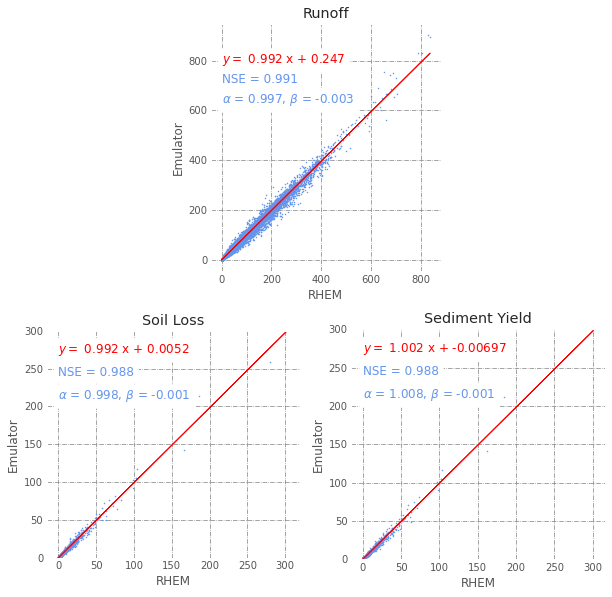

In [23]:
plt.style.use('ggplot')
plt.rcParams['axes.facecolor']='white'
np.set_printoptions(suppress=True)

slope, intercept, r_value, p_value, std_err = linregress(observed_runOff_NRI, predict_runOff_NRI)
r_squared_runOff = r2_score(observed_runOff_NRI, predict_runOff_NRI)
alpha_runoff = np.std(predict_runOff_NRI)/np.std(observed_runOff_NRI)
beta_runoff = (np.mean(predict_runOff_NRI) - np.mean(observed_runOff_NRI))/np.std(observed_runOff_NRI)

slope1, intercept1, r_value1, p_value1, std_err1 = linregress(observed_soilLoss_NRI, predict_soilLoss_NRI)
r_squared_soil = r2_score(observed_soilLoss_NRI, predict_soilLoss_NRI)
alpha_soilLoss = np.std(predict_soilLoss_NRI)/np.std(observed_soilLoss_NRI)
beta_soilLoss = (np.mean(predict_soilLoss_NRI) - np.mean(observed_soilLoss_NRI))/np.std(observed_soilLoss_NRI)

slope2, intercept2, r_value2, p_value2, std_err2 = linregress(observed_sedYield_NRI, predict_sedYield_NRI)
r_squared_sedYield = r2_score(observed_sedYield_NRI, predict_sedYield_NRI)
alpha_sedYield = np.std(predict_sedYield_NRI)/np.std(observed_sedYield_NRI)
beta_sedYield = (np.mean(predict_sedYield_NRI) - np.mean(observed_sedYield_NRI))/np.std(observed_sedYield_NRI)

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Helvetica'

font = {'size'   : 14}

fig = plt.figure(figsize=(10,10))
gs = gridspec.GridSpec(2, 4, figure=fig)
ax1 = fig.add_subplot(gs[0, 1:3], aspect='equal')
ax2 = fig.add_subplot(gs[1, :2], aspect='equal')
ax3 = fig.add_subplot(gs[1, 2:], aspect='equal')

ax1.grid(color='gray', linestyle='-.', linewidth=0.7)
ax1.plot(np.asarray(observed_runOff_NRI), slope*np.asarray(observed_runOff_NRI) + intercept, color='red', linewidth=1)
ax1.scatter(observed_runOff_NRI, predict_runOff_NRI, color='cornflowerblue', s=1, rasterized=True)
ax1.text(0.05, 790, r'$y = $ {} x $ + $ {}'.format(np.round(slope,3), np.round(intercept,3)), color='red', fontsize=12, bbox=dict(facecolor='white', edgecolor='white'))
ax1.text(0.05, 710, r'NSE = {}'.format(np.round(r_squared_runOff,3)), color='cornflowerblue', fontsize=12, bbox=dict(facecolor='white', edgecolor='white'))
ax1.text(0.05, 630, r'$\alpha$ = {}, $\beta$ = {}'.format(np.round(alpha_runoff,3), np.round(beta_runoff,3)), color='cornflowerblue', fontsize=12, bbox=dict(facecolor='white', edgecolor='white'))
ax1.set_title('Runoff')
ax1.set_xlabel('RHEM')
ax1.set_ylabel('Emulator')

ax2.grid(color='gray', linestyle='-.', linewidth=0.7)
ax2.plot(np.asarray(observed_soilLoss_NRI), slope1*np.asarray(observed_soilLoss_NRI) + intercept1, color='red', linewidth=1)
ax2.scatter(observed_soilLoss_NRI, predict_soilLoss_NRI, color='cornflowerblue', s=1, rasterized=True)
ax2.text(0.05, 270, r'$y = $ {} x $ + $ {}'.format(np.round(slope1,3), np.round(intercept1,4)), color='red', fontsize=12, bbox=dict(facecolor='white', edgecolor='white'))
ax2.text(0.05, 240, r'NSE = {}'.format(np.round(r_squared_soil,3)), color='cornflowerblue', fontsize=12, bbox=dict(facecolor='white', edgecolor='white'))
ax2.text(0.05, 210, r'$\alpha$ = {}, $\beta$ = {}'.format(np.round(alpha_soilLoss,3), np.round(beta_soilLoss,3)), color='cornflowerblue', fontsize=12, bbox=dict(facecolor='white', edgecolor='white'))
ax2.set_title('Soil Loss')
ax2.set_xlabel('RHEM')
ax2.set_ylabel('Emulator')
ax2.set_ylim(-0.01,300)

ax3.grid(color='gray', linestyle='-.', linewidth=0.7)
ax3.plot(np.asarray(observed_sedYield_NRI), slope1*np.asarray(observed_sedYield_NRI) + intercept2, color='red', linewidth=1)
ax3.scatter(observed_sedYield_NRI, predict_sedYield_NRI, color='cornflowerblue', s=1, rasterized=True)
ax3.text(0.05, 270, r'$y = $ {} x $ + $ {}'.format(np.round(slope2,3), f"{intercept2:.5f}"), color='red', fontsize=12, bbox=dict(facecolor='white', edgecolor='white'))
ax3.text(0.05, 240, r'NSE = {}'.format(np.round(r_squared_sedYield,3)), color='cornflowerblue', fontsize=12, bbox=dict(facecolor='white', edgecolor='white'))
ax3.text(0.05, 210, r'$\alpha$ = {}, $\beta$ = {}'.format(np.round(alpha_sedYield,3), np.round(beta_sedYield,3)), color='cornflowerblue', fontsize=12, bbox=dict(facecolor='white', edgecolor='white'))
ax3.set_title('Sediment Yield')
ax3.set_xlabel('RHEM')
ax3.set_ylabel('Emulator')
ax3.set_ylim(-0.01,300)

plt.subplots_adjust(hspace=0.2,
                    wspace=0.5)


After evaluating the fine-tuned Emulator with the out-of-sample test data in the cross validation loop, we are ready to make the final fine_tuned Emulator trained with the entire NRI scenarios.

In [24]:
NRIdataset = pd.read_csv('Files/Data/NRI_dataset.csv')
NRIdataset = NRIdataset.sample(n=len(NRIdataset.index))

## create the boolean runoff and soil loss columns
NRIdataset['runoff_bool'] = np.where(NRIdataset['runoff'] == 0,0,1)
NRIdataset['soilLoss_bool'] = np.where((NRIdataset['soilLoss'] == 0) & (NRIdataset['runoff'] != 0),0,1)

## define x and y
x_train = NRIdataset.loc[:, ['prcp', 'dur', 'tp', 'ip',
                   'SL1', 'SL2', 'G', 'DIST', 'POR', 'SMAX',
                   'FRACT1', 'FRACT2', 'FRACT3', 'FRACT4', 'FRACT5',
                   'Litter', 'BiologicalCrusts', 'Basal',
                   'Rock', 'totalGround', 'Forbs',
                   'BunchGrass', 'Shrubs', 'SodGrass',
                   'totalFoliar']].values
y_train = NRIdataset.loc[:, ['runoff_bool','soilLoss_bool', 'runoff', 'soilLoss', 'sedYield']].values

## normalize the NRI's inputs using the normalizer that has been fit to the training set 
x_train[:,[0,1,3,6]] = minmaxt_x.transform(x_train[:,[0,1,3,6]])
x_train[:,15:] = x_train[:,15:]/100

# log transform and normalization of the runoff, soil loss and sediment yield
runoff_zero = np.where(y_train[:,2] == 0.)
soliLoss_zero = np.where(y_train[:,3] == 0.)
sedYield_zero = np.where(y_train[:,4] == 0.)
soliLoss_nonzero = np.where(y_train[:,3] != 0.)
y_train[:,2] = np.where(y_train[:,2]==0, 0, np.log(y_train[:,2]))
y_train[:,3] = np.where(y_train[:,3]==0, 0, np.log(y_train[:,3]))
y_train[:,4] = np.where(y_train[:,4]==0, 0, np.log(y_train[:,4]))
y_train[:,[2]] = minmaxt_y_runoff.transform(y_train[:,[2]])
y_train[:,[3]] = minmaxt_y_erosion.transform(y_train[:,[3]])
y_train[:,[4]] = minmaxt_y_erosion.transform(y_train[:,[4]])
y_train[runoff_zero,[2]] = 0.
y_train[soliLoss_zero,[3]] = 0.
y_train[sedYield_zero,[4]] = 0.

## Load the trained emulator
print('Load the pre-trained Emulator')
emulator1 = tf.keras.models.load_model('Files/Trained_Emulator/emulator.h5', custom_objects={ 'weighted_binary_crossentropy': weighted_binary_crossentropy()})

## deactivate the batch normalization layers and compile the model again 
## (see https://www.tensorflow.org/guide/keras/transfer_learning#fine-tuning for more details)
print('Preparing and recompiling the Emulator')
for layer in emulator1.layers:
    if layer.name[:19] == 'batch_normalization':
        layer.trainable = False
emulator1.compile(loss={'runoff_mul':weighted_binary_crossentropy(1,1), 'soilLoss_mul':weighted_binary_crossentropy(1,1), 'Q_runoff':'mse', 'soilLoss':'mse', 'sedYield':'mse'}, 
                        optimizer=tf.keras.optimizers.Adam(initial), metrics={'runoff_mul':'binary_accuracy','soilLoss_mul':'binary_accuracy','Q_runoff':'mae', 'soilLoss':'mae', 'sedYield':'mae'})

## Retrain the emulator (epochs:100, batch_size:1000)
print('Retraining the Emulator...')
emulator1.fit(x_train, [y_train[:,0:1].astype(int), y_train[:,1:2].astype(int), y_train[:,2:3], y_train[:,3:4], y_train[:,4:]], 
              epochs = b*2, batch_size=1000, callbacks=[callback3], verbose=0)
print('Done')

/home/kia/anaconda3/envs/rhem/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in log
/home/kia/anaconda3/envs/rhem/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in log


Load the pre-trained Emulator
Preparing and recompiling the Emulator
Retraining the Emulator...
Done


### Sensitivity Analysis of the RHEM vs. the Emulator (Section 4.4 of the paper, Figure 5)
After evaluating the accuracy of the Emulator in estimating the RHEM outputs, it is time to investigate other aspects of it to see if it can fully resemble the RHEM. Global sensitivity analysis (GSA) allows us to compare the average responses of RHEM and the Emulator to each input variable. Run the cell below to see if they both have similar response.

If you already run the cross validation loop of the Emulator, ignore the cell. Otherwise run the this cell to load the cross validation results which is required for the sensitivity analysis.

In [26]:
with open('Files/Cross-Validation_Results/predict_runOff.pkl', 'rb') as file:
    predict_runOff = pickle.load(file)
with open('Files/Cross-Validation_Results/observed_runOff.pkl', 'rb') as file:
    observed_runOff = pickle.load(file)
    
with open('Files/Cross-Validation_Results/predict_soilLoss.pkl', 'rb') as file:
    predict_soilLoss = pickle.load(file)
with open('Files/Cross-Validation_Results/observed_soilLoss.pkl', 'rb') as file:
    observed_soilLoss = pickle.load(file)

with open('Files/Cross-Validation_Results/predict_sedYield.pkl', 'rb') as file:
    predict_sedYield = pickle.load(file)
with open('Files/Cross-Validation_Results/observed_sedYield.pkl', 'rb') as file:
    observed_sedYield = pickle.load(file)

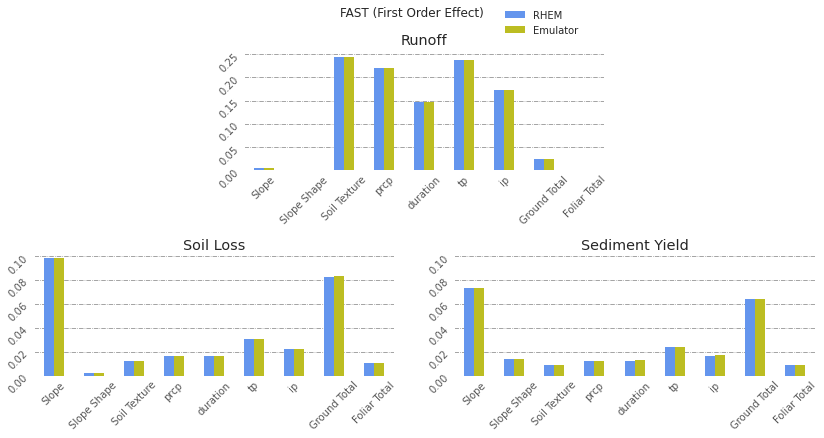

In [27]:
## See https://salib.readthedocs.io/en/latest/ for the impelementation details of the FAST sensitivity analysis

## the variables and their bounds for the analysis (see table 1)
problem = {
    'num_vars': 9,
    'names': ['Slope',
              'Slope Shape',
              
              'Soil Texture',
              
              'prcp',
              'duration',
              'tp',
              'ip',
              
              'Ground Total',
              'Foliar Total'],
    
    'bounds': [[0.1, 100],
               
               [0, 3],
               [0,12],
               
               [2.395807, 23.232297],
               [1.216081, 14.772784],
               [0.07826, 0.295656],
               [2.596139, 5.608074],
               
               
               [0, 100],
               [0, 100]]
}

## define x of the analysis for FAST
x = dataset.loc[:, ['slope', 'slopeShape', 'soil', 'prcp', 'dur', 'tp', 'ip', 'totalGround', 'totalFoliar']]
x['slopeShape'] = x['slopeShape'].astype('category').cat.codes
x['soil'] = x['soil'].astype('category').cat.codes
x = x.values

## FAST sensitivity analysis
S_runoff_rhem_fast = fast(problem, x, np.asarray(observed_runOff))
S_soilLoss_rhem_fast = fast(problem, x, np.asarray(observed_soilLoss))
S_sedYield_rhem_fast = fast(problem, x, np.asarray(observed_sedYield))

S_runoff_emulator_fast = fast(problem, x, np.asarray(predict_runOff))
S_soilLoss_emulator_fast = fast(problem, x, np.asarray(predict_soilLoss))
S_sedYield_emulator_fast = fast(problem, x, np.asarray(predict_sedYield))

## plot the results
values_runoff = S_runoff_rhem_fast['S1']
titles_runoff = S_runoff_rhem_fast['names']

values_soilLoss = S_soilLoss_rhem_fast['S1']
titles_soilLoss = S_soilLoss_rhem_fast['names']

values_sedYield = S_sedYield_rhem_fast['S1']
titles_sedYield = S_sedYield_rhem_fast['names']

values_runoff_model = S_runoff_emulator_fast['S1']
titles_runoff_model = S_runoff_emulator_fast['names']

values_soilLoss_model = S_soilLoss_emulator_fast['S1']
titles_soilLoss_model = S_soilLoss_emulator_fast['names']

values_sedYield_model = S_sedYield_emulator_fast['S1']
titles_sedYield_model = S_sedYield_emulator_fast['names']

outputList = ['RHEM', 'Emulator']

df_runoff = pd.DataFrame(np.zeros((9,2)),
                 index=titles_runoff,
                 columns=pd.Index(outputList, 
                 name='Variable'))

df_runoff['RHEM'] = values_runoff
df_runoff['Emulator'] = values_runoff_model

plt.style.use('ggplot')
plt.rcParams['axes.facecolor']='white'
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Helvetica'

fig = plt.figure(figsize=(10,10))
plt.suptitle('FAST (First Order Effect)')
gs = gridspec.GridSpec(2, 4, figure=fig)
ax1 = fig.add_subplot(gs[0, 1:3])
ax2 = fig.add_subplot(gs[1, :2])
ax3 = fig.add_subplot(gs[1, 2:])

df_runoff.plot(kind='bar',figsize=(14,6), 
               title = 'Runoff', 
               color=['cornflowerblue', 'tab:olive'], 
               ax=(ax1), 
               legend=False)
ax1.grid(color='gray', linestyle='-.', linewidth=0.7, axis='y')
ax1.tick_params(labelrotation=45)
ax1.set_ylim([0, 0.26])
legend = ax1.legend(frameon=True, bbox_to_anchor=(0.7, 1.4), loc='upper left')
frame = legend.get_frame()
frame.set_facecolor('white')
frame.set_edgecolor('white')
frame.set_alpha(None)
##################################################################
df_soilLoss = pd.DataFrame(np.zeros((9,2)),
                 index=titles_soilLoss,
                 columns=pd.Index(outputList, 
                 name='Variable'))

df_soilLoss['RHEM'] = values_soilLoss
df_soilLoss['Emulator'] = values_soilLoss_model


df_soilLoss.plot(kind='bar',figsize=(14,6), 
                 title = 'Soil Loss', 
                 legend=False, 
                 color=['cornflowerblue', 'tab:olive'], 
                 ax=(ax2))
ax2.grid(color='gray', linestyle='-.', linewidth=0.7, axis='y')
ax2.tick_params(labelrotation=45)
ax2.set_ylim([0, 0.101])
###################################################################
df_sedYield = pd.DataFrame(np.zeros((9,2)),
                 index=titles_sedYield,
                 columns=pd.Index(outputList, 
                 name='Variable'))

df_sedYield['RHEM'] = values_sedYield
df_sedYield['Emulator'] = values_sedYield_model


df_sedYield.plot(kind='bar',figsize=(14,6), 
                 title = 'Sediment Yield', 
                 legend=False, 
                 color=['cornflowerblue', 'tab:olive'], 
                 ax=(ax3))
ax3.grid(color='gray', linestyle='-.', linewidth=0.7, axis='y')
ax3.tick_params(labelrotation=45)
ax3.set_ylim([0, 0.101])

plt.subplots_adjust(hspace=0.7,
                    wspace=0.4)


### Change in the Emulator Prediction by Altering the values of the variables (Section 4.5, Figure 6)

The next evaluation of the Emulator is to see how its outputs change when we modify the values of all but one input variables. Comparing this change pattern to what we get from the RHEM could be an Emulator evaluation step. We have created the required scenarios to perform the experiment (see section 2.5 of the paper) and run them with the RHEM and the Emulator. So you will just load them in the following cells.

- For the Ground Cover Categories:

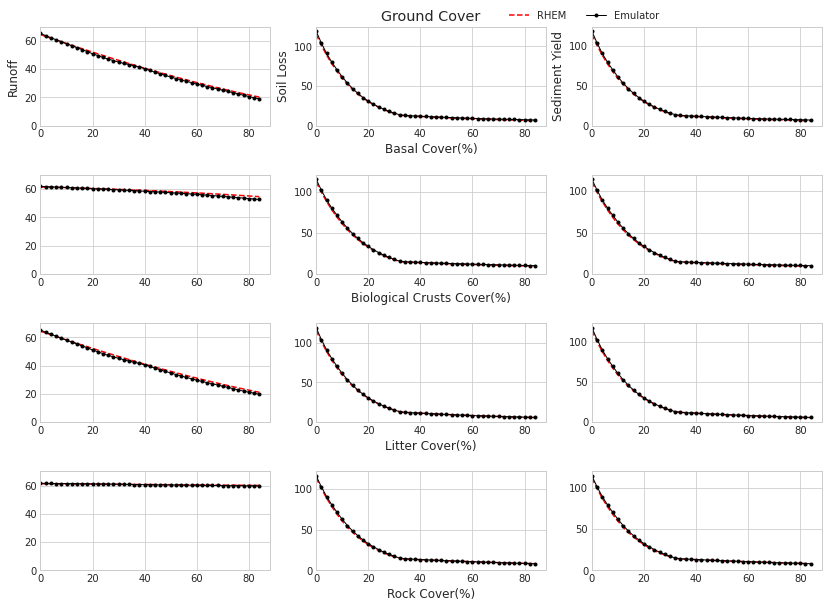

In [28]:
fig = plt.figure(figsize=(14,10))
gs = gridspec.GridSpec(4, 3, figure=fig)

plt.style.use('seaborn-whitegrid')
np.set_printoptions(suppress=True)

var_name = 'Basal'
scenarios = pd.read_csv('Change_Pattern_Evaluation/{}Scenarios/{}_results_pred.csv'.format(var_name, 
                                                                           var_name)).sort_values(var_name)

ax1 = fig.add_subplot(gs[0, 0])
x = scenarios.Basal.values
y = scenarios.runoff.values
y1 = scenarios.pred_runoff.values

slope1, _, _, _, _ = linregress(x, y)
ax1.plot(x, y, linestyle='--', color='red', label='RHEM', linewidth=1.5)
slope1, _, _, _, _ = linregress(x, y1)
ax1.plot(x, y1, marker='o', color='black', label='Emulator', linewidth=1., markersize=3)

ax1.set_xlim((0,None))
ax1.set_ylim((0,70))
ax1.set_ylabel('Runoff')
#ax1.legend(loc="upper right")

ax2 = fig.add_subplot(gs[0, 1])

x = scenarios.Basal.values
y = scenarios.soilLoss.values
y1 = scenarios.pred_soilLoss.values

slope1, _, _, _, _ = linregress(x, y)
ax2.plot(x, y, linestyle='--', color='red', label='slope={}'.format(np.round(slope1, 3)), linewidth=1.5)
slope1, _, _, _, _ = linregress(x, y1)
ax2.plot(x, y1, marker='o', color='black', label='slope={}'.format(np.round(slope1, 3)), linewidth=1., 
         markersize=3)

ax2.set_xlim((0,None))
ax2.set_ylim((0,None))
ax2.set_xlabel('Basal Cover(%)')
ax2.set_ylabel('Soil Loss')
ax2.set_title('Ground Cover')

ax3 = fig.add_subplot(gs[0, 2])

x = scenarios.Basal.values
y = scenarios.sedYield.values
y1 = scenarios.pred_sedYield.values

slope1, _, _, _, _ = linregress(x, y)
ax3.plot(x, y, linestyle='--', color='red', label='RHEM', linewidth=1.5)
slope1, _, _, _, _ = linregress(x, y1)
ax3.plot(x, y1, marker='o', color='black', label='Emulator', linewidth=1., markersize=3)

ax3.set_xlim((0,None))
ax3.set_ylim((0,None))
ax3.set_ylabel('Sediment Yield')
ax3.legend(frameon = 0, bbox_to_anchor=(-0.4, 1.25), loc='upper left', ncol=2)


################################

var_name = 'Biological'
scenarios = pd.read_csv('Change_Pattern_Evaluation/{}Scenarios/{}_results_pred.csv'.format(var_name, 
                                                                           var_name)).sort_values('BiologicalCrusts')

ax1 = fig.add_subplot(gs[1, 0])
x = scenarios.BiologicalCrusts.values
y = scenarios.runoff.values
y1 = scenarios.pred_runoff.values

slope1, _, _, _, _ = linregress(x, y)
ax1.plot(x, y, linestyle='--', color='red', label='slope={}'.format(np.round(slope1, 3)), linewidth=1.5)
slope1, _, _, _, _ = linregress(x, y1)
ax1.plot(x, y1, marker='o', color='black', label='slope={}'.format(np.round(slope1, 3)), linewidth=1., 
         markersize=3)

ax1.set_xlim((0,None))
ax1.set_ylim((0,70))

ax2 = fig.add_subplot(gs[1, 1])

x = scenarios.BiologicalCrusts.values
y = scenarios.soilLoss.values
y1 = scenarios.pred_soilLoss.values

slope1, _, _, _, _ = linregress(x, y)
ax2.plot(x, y, linestyle='--', color='red', label='slope={}'.format(np.round(slope1, 4)), linewidth=1.5)
slope1, _, _, _, _ = linregress(x, y1)
ax2.plot(x, y1, marker='o', color='black', label='slope={}'.format(np.round(slope1, 4)), linewidth=1., 
         markersize=3)

ax2.set_xlim((0,None))
ax2.set_ylim((0,None))
ax2.set_xlabel('Biological Crusts Cover(%)')

ax3 = fig.add_subplot(gs[1, 2])

x = scenarios.BiologicalCrusts.values
y = scenarios.sedYield.values
y1 = scenarios.pred_sedYield.values

slope1, _, _, _, _ = linregress(x, y)
ax3.plot(x, y, linestyle='--', color='red', label='slope={}'.format(np.round(slope1, 4)), linewidth=1.5)
slope1, _, _, _, _ = linregress(x, y1)
ax3.plot(x, y1, marker='o', color='black', label='slope={}'.format(np.round(slope1, 4)), linewidth=1., 
         markersize=3)

ax3.set_xlim((0,None))
ax3.set_ylim((0,None))

####################################
var_name = 'Litter'
scenarios = pd.read_csv('Change_Pattern_Evaluation/{}Scenarios/{}_results_pred.csv'.format(var_name, 
                                                                           var_name)).sort_values(var_name)

ax1 = fig.add_subplot(gs[2, 0])
x = scenarios.Litter.values
y = scenarios.runoff.values
y1 = scenarios.pred_runoff.values

slope1, _, _, _, _ = linregress(x, y)
ax1.plot(x, y, linestyle='--', color='red', label='slope={}'.format(np.round(slope1, 2)), linewidth=1.5)
slope1, _, _, _, _ = linregress(x, y1)
ax1.plot(x, y1, marker='o', color='black', label='slope={}'.format(np.round(slope1, 2)), linewidth=1., 
         markersize=3)

ax1.set_xlim((0,None))
ax1.set_ylim((0,70))

ax2 = fig.add_subplot(gs[2, 1])

x = scenarios.Litter.values
y = scenarios.soilLoss.values
y1 = scenarios.pred_soilLoss.values

slope1, _, _, _, _ = linregress(x, y)
ax2.plot(x, y, linestyle='--', color='red', label='slope={}'.format(np.round(slope1, 3)), linewidth=1.5)
slope1, _, _, _, _ = linregress(x, y1)
ax2.plot(x, y1, marker='o', color='black', label='slope={}'.format(np.round(slope1, 3)), linewidth=1., 
         markersize=3)

ax2.set_xlim((0,None))
ax2.set_ylim((0,None))
ax2.set_xlabel('Litter Cover(%)')

ax3 = fig.add_subplot(gs[2, 2])

x = scenarios.Litter.values
y = scenarios.sedYield.values
y1 = scenarios.pred_sedYield.values

slope1, _, _, _, _ = linregress(x, y)
ax3.plot(x, y, linestyle='--', color='red', label='slope={}'.format(np.round(slope1, 3)), linewidth=1.5)
slope1, _, _, _, _ = linregress(x, y1)
ax3.plot(x, y1, marker='o', color='black', label='slope={}'.format(np.round(slope1, 3)), linewidth=1., 
         markersize=3)

ax3.set_xlim((0,None))
ax3.set_ylim((0,None))

###################################
var_name = 'Rock'
scenarios = pd.read_csv('Change_Pattern_Evaluation/{}Scenarios/{}_results_pred.csv'.format(var_name, 
                                                                           var_name)).sort_values(var_name)

ax1 = fig.add_subplot(gs[3, 0])
x = scenarios.Rock.values
y = scenarios.runoff.values
y1 = scenarios.pred_runoff.values

slope1, _, _, _, _ = linregress(x, y)
ax1.plot(x, y, linestyle='--', color='red', label='slope={}'.format(np.round(slope1, 3)), linewidth=1.5)
slope1, _, _, _, _ = linregress(x, y1)
ax1.plot(x, y1, marker='o', color='black', label='slope={}'.format(np.round(slope1, 3)), linewidth=1., 
         markersize=3)

ax1.set_xlim((0,None))
ax1.set_ylim((0,70))

ax2 = fig.add_subplot(gs[3, 1])

x = scenarios.Rock.values
y = scenarios.soilLoss.values
y1 = scenarios.pred_soilLoss.values

slope1, _, _, _, _ = linregress(x, y)
ax2.plot(x, y, linestyle='--', color='red', label='slope={}'.format(np.round(slope1, 4)), linewidth=1.5)
slope1, _, _, _, _ = linregress(x, y1)
ax2.plot(x, y1, marker='o', color='black', label='slope={}'.format(np.round(slope1, 4)), linewidth=1, 
         markersize=3)

ax2.set_xlim((0,None))
ax2.set_ylim((0,None))
ax2.set_xlabel('Rock Cover(%)')

ax3 = fig.add_subplot(gs[3, 2])

x = scenarios.Rock.values
y = scenarios.sedYield.values
y1 = scenarios.pred_sedYield.values

slope1, _, _, _, _ = linregress(x, y)
ax3.plot(x, y, linestyle='--', color='red', label='slope={}'.format(np.round(slope1, 4)), linewidth=1.5)
slope1, _, _, _, _ = linregress(x, y1)
ax3.plot(x, y1, marker='o', color='black', label='slope={}'.format(np.round(slope1, 4)), linewidth=1, 
         markersize=3)

ax3.set_xlim((0,None))
ax3.set_ylim((0,None))

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Helvetica'
plt.subplots_adjust(hspace=0.5)


- For the Foliar Cover Categories:

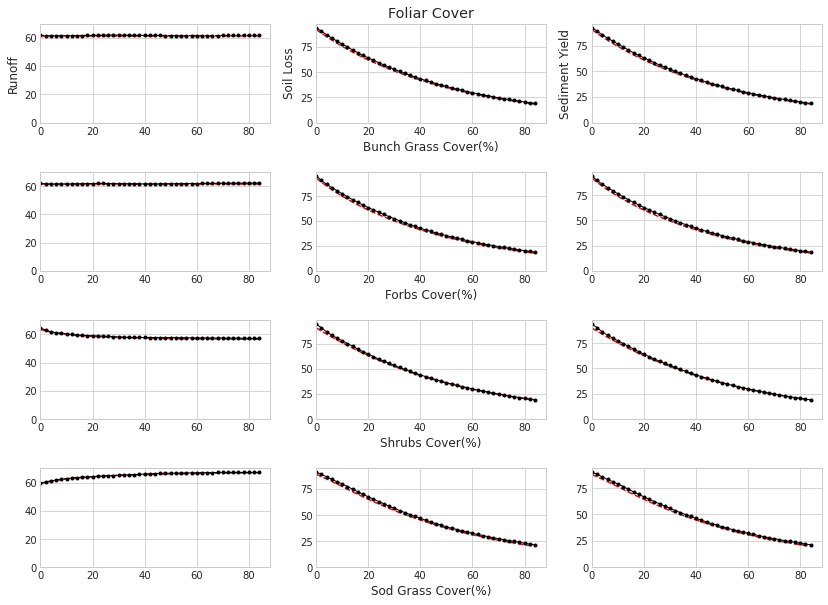

In [29]:
fig = plt.figure(figsize=(14,10))
gs = gridspec.GridSpec(4, 3, figure=fig)

plt.style.use('seaborn-whitegrid')
np.set_printoptions(suppress=True)

var_name = 'Bunch'
scenarios = pd.read_csv('Change_Pattern_Evaluation/{}Scenarios/{}_results_pred.csv'.format(var_name, 
                                                                           var_name)).sort_values('BunchGrass')

ax1 = fig.add_subplot(gs[0, 0])
x = scenarios.BunchGrass.values
y = scenarios.runoff.values
y1 = scenarios.pred_runoff.values

slope1, _, _, _, _ = linregress(x, y)
ax1.plot(x, y, linestyle='--', color='red', label='slope={}'.format(np.round(slope1, 3)), linewidth=1.5)
slope1, _, _, _, _ = linregress(x, y1)
ax1.plot(x, y1, linestyle='--', marker='o', color='black', label='slope={}'.format(np.round(slope1, 3)), 
         linewidth=1., markersize=3)

ax1.set_xlim((0,None))
ax1.set_ylim((0,70))
ax1.set_ylabel('Runoff')

ax2 = fig.add_subplot(gs[0, 1])

x = scenarios.BunchGrass.values
y = scenarios.soilLoss.values
y1 = scenarios.pred_soilLoss.values

slope1, _, _, _, _ = linregress(x, y)
ax2.plot(x, y, linestyle='--', color='red', label='slope={}'.format(np.round(slope1, 3)), linewidth=1.5)
slope1, _, _, _, _ = linregress(x, y1)
ax2.plot(x, y1, marker='o', color='black', label='slope={}'.format(np.round(slope1, 3)), linewidth=1., 
         markersize=3)

ax2.set_xlim((0,None))
ax2.set_ylim((0,None))
ax2.set_xlabel('Bunch Grass Cover(%)')
ax2.set_ylabel('Soil Loss')
ax2.set_title('Foliar Cover')

ax3 = fig.add_subplot(gs[0, 2])

x = scenarios.BunchGrass.values
y = scenarios.sedYield.values
y1 = scenarios.pred_sedYield.values

slope1, _, _, _, _ = linregress(x, y)
ax3.plot(x, y, linestyle='--', color='red', label='slope={}'.format(np.round(slope1, 3)), linewidth=1.5)
slope1, _, _, _, _ = linregress(x, y1)
ax3.plot(x, y1, marker='o', color='black', label='slope={}'.format(np.round(slope1, 3)), linewidth=1., 
         markersize=3)

ax3.set_xlim((0,None))
ax3.set_ylim((0,None))
ax3.set_ylabel('Sediment Yield')

################################

var_name = 'Forbs'
scenarios = pd.read_csv('Change_Pattern_Evaluation/{}Scenarios/{}_results_pred.csv'.format(var_name, 
                                                                           var_name)).sort_values('Forbs')

ax1 = fig.add_subplot(gs[1, 0])
x = scenarios.Forbs.values
y = scenarios.runoff.values
y1 = scenarios.pred_runoff.values

slope1, _, _, _, _ = linregress(x, y)
ax1.plot(x, y, linestyle='--', color='red', label='slope={}'.format(np.round(slope1, 3)), linewidth=1.5)
slope1, _, _, _, _ = linregress(x, y1)
ax1.plot(x, y1, marker='o', color='black', label='slope={}'.format(np.round(slope1, 3)), linewidth=1., 
         markersize=3)

ax1.set_xlim((0,None))
ax1.set_ylim((0,70))

ax2 = fig.add_subplot(gs[1, 1])

x = scenarios.Forbs.values
y = scenarios.soilLoss.values
y1 = scenarios.pred_soilLoss.values

slope1, _, _, _, _ = linregress(x, y)
ax2.plot(x, y, linestyle='--', color='red', label='slope={}'.format(np.round(slope1, 4)), linewidth=1.5)
slope1, _, _, _, _ = linregress(x, y1)
ax2.plot(x, y1, marker='o', color='black', label='slope={}'.format(np.round(slope1, 4)), linewidth=1., 
         markersize=3)

ax2.set_xlim((0,None))
ax2.set_ylim((0,None))
ax2.set_xlabel('Forbs Cover(%)')

ax3 = fig.add_subplot(gs[1, 2])

x = scenarios.Forbs.values
y = scenarios.sedYield.values
y1 = scenarios.pred_sedYield.values

slope1, _, _, _, _ = linregress(x, y)
ax3.plot(x, y, linestyle='--', color='red', label='slope={}'.format(np.round(slope1, 4)), linewidth=1.5)
slope1, _, _, _, _ = linregress(x, y1)
ax3.plot(x, y1, marker='o', color='black', label='slope={}'.format(np.round(slope1, 4)), linewidth=1., 
         markersize=3)

ax3.set_xlim((0,None))
ax3.set_ylim((0,None))

####################################
var_name = 'Shrubs'
scenarios = pd.read_csv('Change_Pattern_Evaluation/{}Scenarios/{}_results_pred.csv'.format(var_name, 
                                                                           var_name)).sort_values(var_name)

ax1 = fig.add_subplot(gs[2, 0])
x = scenarios.Shrubs.values
y = scenarios.runoff.values
y1 = scenarios.pred_runoff.values

slope1, _, _, _, _ = linregress(x, y)
ax1.plot(x, y, linestyle='--', color='red', label='slope={}'.format(np.round(slope1, 2)), linewidth=1.5)
slope1, _, _, _, _ = linregress(x, y1)
ax1.plot(x, y1, marker='o', color='black', label='slope={}'.format(np.round(slope1, 2)), linewidth=1., 
         markersize=3)

ax1.set_xlim((0,None))
ax1.set_ylim((0,70))

ax2 = fig.add_subplot(gs[2, 1])

x = scenarios.Shrubs.values
y = scenarios.soilLoss.values
y1 = scenarios.pred_soilLoss.values

slope1, _, _, _, _ = linregress(x, y)
ax2.plot(x, y, linestyle='--', color='red', label='slope={}'.format(np.round(slope1, 3)), linewidth=1.5)
slope1, _, _, _, _ = linregress(x, y1)
ax2.plot(x, y1, marker='o', color='black', label='slope={}'.format(np.round(slope1, 3)), linewidth=1., 
         markersize=3)

ax2.set_xlim((0,None))
ax2.set_ylim((0,None))
ax2.set_xlabel('Shrubs Cover(%)')

ax3 = fig.add_subplot(gs[2, 2])

x = scenarios.Shrubs.values
y = scenarios.sedYield.values
y1 = scenarios.pred_sedYield.values

slope1, _, _, _, _ = linregress(x, y)
ax3.plot(x, y, linestyle='--', color='red', label='slope={}'.format(np.round(slope1, 3)), linewidth=1.5)
slope1, _, _, _, _ = linregress(x, y1)
ax3.plot(x, y1, marker='o', color='black', label='slope={}'.format(np.round(slope1, 3)), linewidth=1., 
         markersize=3)

ax3.set_xlim((0,None))
ax3.set_ylim((0,None))

###################################
var_name = 'Sod'
scenarios = pd.read_csv('Change_Pattern_Evaluation/{}Scenarios/{}_results_pred.csv'.format(var_name, 
                                                                           var_name)).sort_values('SodGrass')

ax1 = fig.add_subplot(gs[3, 0])
x = scenarios.SodGrass.values
y = scenarios.runoff.values
y1 = scenarios.pred_runoff.values

slope1, _, _, _, _ = linregress(x, y)
ax1.plot(x, y, linestyle='--', color='red', label='slope={}'.format(np.round(slope1, 2)), linewidth=1.5)
slope1, _, _, _, _ = linregress(x, y1)
ax1.plot(x, y1, marker='o', color='black', label='slope={}'.format(np.round(slope1, 2)), linewidth=1., 
         markersize=3)

ax1.set_xlim((0,None))
ax1.set_ylim((0,70))

ax2 = fig.add_subplot(gs[3, 1])

x = scenarios.SodGrass.values
y = scenarios.soilLoss.values
y1 = scenarios.pred_soilLoss.values

slope1, _, _, _, _ = linregress(x, y)
ax2.plot(x, y, linestyle='--', color='red', label='slope={}'.format(np.round(slope1, 4)), linewidth=1.5)
slope1, _, _, _, _ = linregress(x, y1)
ax2.plot(x, y1, marker='o', color='black', label='slope={}'.format(np.round(slope1, 4)), linewidth=1., 
         markersize=3)

ax2.set_xlim((0,None))
ax2.set_ylim((0,None))
ax2.set_xlabel('Sod Grass Cover(%)')
ax3 = fig.add_subplot(gs[3, 2])

x = scenarios.SodGrass.values
y = scenarios.sedYield.values
y1 = scenarios.pred_sedYield.values

slope1, _, _, _, _ = linregress(x, y)
ax3.plot(x, y, linestyle='--', color='red', label='slope={}'.format(np.round(slope1, 4)), linewidth=1.5)
slope1, _, _, _, _ = linregress(x, y1)
ax3.plot(x, y1, marker='o', color='black', label='slope={}'.format(np.round(slope1, 4)), linewidth=1., 
         markersize=3)

ax3.set_xlim((0,None))
ax3.set_ylim((0,None))

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Helvetica'
plt.subplots_adjust(hspace=0.5)


- For the CLIGEN variables:

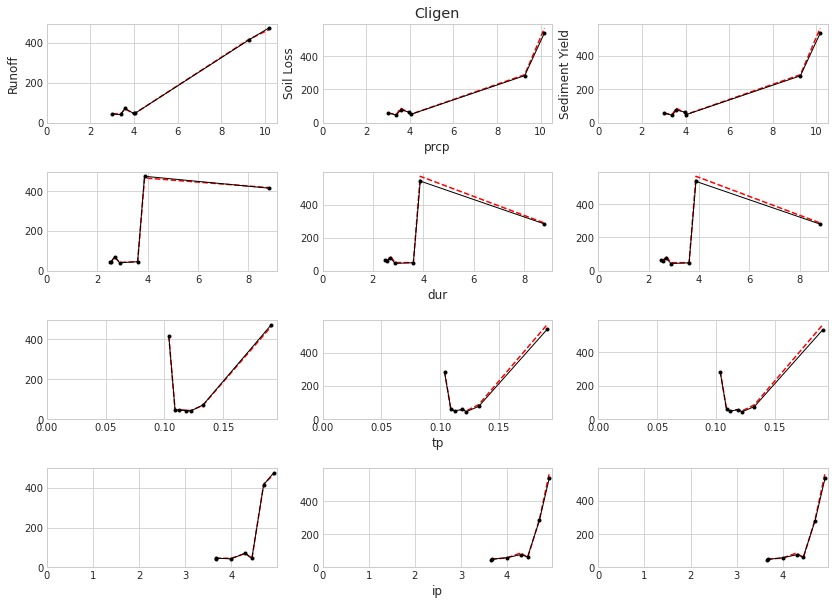

In [31]:
fig = plt.figure(figsize=(14,10))
gs = gridspec.GridSpec(4, 3, figure=fig)

plt.style.use('seaborn-whitegrid')
np.set_printoptions(suppress=True)

var_name = 'cligen'
scenarios = pd.read_csv('Change_Pattern_Evaluation/{}Scenarios/{}_results_pred.csv'.
                        format(var_name, var_name)).sort_values('prcp')

ax1 = fig.add_subplot(gs[0, 0])
x = scenarios.prcp.values
y = scenarios.runoff.values
y1 = scenarios.pred_runoff.values

slope1, _, _, _, _ = linregress(x, y)
ax1.plot(x, y, linestyle='--', color='red', label='slope={}'.format(np.round(slope1, 3)), linewidth=1.5)
slope1, _, _, _, _ = linregress(x, y1)
ax1.plot(x, y1, marker='o', color='black', label='slope={}'.format(np.round(slope1, 3)), linewidth=1., 
         markersize=3)

ax1.set_xlim((0,None))
ax1.set_ylim((0,None))
ax1.set_ylabel('Runoff')

ax2 = fig.add_subplot(gs[0, 1])

x = scenarios.prcp.values
y = scenarios.soilLoss.values
y1 = scenarios.pred_soilLoss.values

slope1, _, _, _, _ = linregress(x, y)
ax2.plot(x, y, linestyle='--', color='red', label='slope={}'.format(np.round(slope1, 3)), linewidth=1.5)
slope1, _, _, _, _ = linregress(x, y1)
ax2.plot(x, y1, marker='o', color='black', label='slope={}'.format(np.round(slope1, 3)), linewidth=1., 
         markersize=3)

ax2.set_xlim((0,None))
ax2.set_ylim((0,None))
ax2.set_xlabel('prcp')
ax2.set_ylabel('Soil Loss')
ax2.set_title('Cligen')

ax3 = fig.add_subplot(gs[0, 2])

x = scenarios.prcp.values
y = scenarios.sedYield.values
y1 = scenarios.pred_sedYield.values

slope1, _, _, _, _ = linregress(x, y)
ax3.plot(x, y, linestyle='--', color='red', label='slope={}'.format(np.round(slope1, 3)), linewidth=1.5)
slope1, _, _, _, _ = linregress(x, y1)
ax3.plot(x, y1, marker='o', color='black', label='slope={}'.format(np.round(slope1, 3)), linewidth=1., 
         markersize=3)

ax3.set_xlim((0,None))
ax3.set_ylim((0,None))
ax3.set_ylabel('Sediment Yield')

################################

var_name = 'cligen'
scenarios = pd.read_csv('Change_Pattern_Evaluation/{}Scenarios/{}_results_pred.csv'.
                        format(var_name, var_name)).sort_values('dur')

ax1 = fig.add_subplot(gs[1, 0])
x = scenarios.dur.values
y = scenarios.runoff.values
y1 = scenarios.pred_runoff.values

slope1, _, _, _, _ = linregress(x, y)
ax1.plot(x, y, linestyle='--', color='red', label='slope={}'.format(np.round(slope1, 3)), linewidth=1.5)
slope1, _, _, _, _ = linregress(x, y1)
ax1.plot(x, y1, marker='o', color='black', label='slope={}'.format(np.round(slope1, 3)), linewidth=1., 
         markersize=3)

ax1.set_xlim((0,None))
ax1.set_ylim((0,None))

ax2 = fig.add_subplot(gs[1, 1])

x = scenarios.dur.values
y = scenarios.soilLoss.values
y1 = scenarios.pred_soilLoss.values

slope1, _, _, _, _ = linregress(x, y)
ax2.plot(x, y, linestyle='--', color='red', label='slope={}'.format(np.round(slope1, 3)), linewidth=1.5)
slope1, _, _, _, _ = linregress(x, y1)
ax2.plot(x, y1, marker='o', color='black', label='slope={}'.format(np.round(slope1, 3)), linewidth=1., 
         markersize=3)

ax2.set_xlim((0,None))
ax2.set_ylim((0,None))
ax2.set_xlabel('dur')

ax3 = fig.add_subplot(gs[1, 2])

x = scenarios.dur.values
y = scenarios.sedYield.values
y1 = scenarios.pred_sedYield.values

slope1, _, _, _, _ = linregress(x, y)
ax3.plot(x, y, linestyle='--', color='red', label='slope={}'.format(np.round(slope1, 3)), linewidth=1.5)
slope1, _, _, _, _ = linregress(x, y1)
ax3.plot(x, y1, marker='o', color='black', label='slope={}'.format(np.round(slope1, 3)), linewidth=1., 
         markersize=3)

ax3.set_xlim((0,None))
ax3.set_ylim((0,None))

####################################
var_name = 'cligen'
scenarios = pd.read_csv('Change_Pattern_Evaluation/{}Scenarios/{}_results_pred.csv'.
                        format(var_name, var_name)).sort_values('tp')

ax1 = fig.add_subplot(gs[2, 0])
x = scenarios.tp.values
y = scenarios.runoff.values
y1 = scenarios.pred_runoff.values

slope1, _, _, _, _ = linregress(x, y)
ax1.plot(x, y, linestyle='--', color='red', label='slope={}'.format(np.round(slope1, 3)), linewidth=1.5)
slope1, _, _, _, _ = linregress(x, y1)
ax1.plot(x, y1, marker='o', color='black', label='slope={}'.format(np.round(slope1, 3)), linewidth=1., 
         markersize=3)

ax1.set_xlim((0,None))
ax1.set_ylim((0,None))

ax2 = fig.add_subplot(gs[2, 1])

x = scenarios.tp.values
y = scenarios.soilLoss.values
y1 = scenarios.pred_soilLoss.values

slope1, _, _, _, _ = linregress(x, y)
ax2.plot(x, y, linestyle='--', color='red', label='slope={}'.format(np.round(slope1, 3)), linewidth=1.5)
slope1, _, _, _, _ = linregress(x, y1)
ax2.plot(x, y1, marker='o', color='black', label='slope={}'.format(np.round(slope1, 3)), linewidth=1., 
         markersize=3)

ax2.set_xlim((0,None))
ax2.set_ylim((0,None))
ax2.set_xlabel('tp')

ax3 = fig.add_subplot(gs[2, 2])

x = scenarios.tp.values
y = scenarios.sedYield.values
y1 = scenarios.pred_sedYield.values

slope1, _, _, _, _ = linregress(x, y)
ax3.plot(x, y, linestyle='--', color='red', label='slope={}'.format(np.round(slope1, 3)), linewidth=1.5)
slope1, _, _, _, _ = linregress(x, y1)
ax3.plot(x, y1, marker='o', color='black', label='slope={}'.format(np.round(slope1, 3)), linewidth=1., 
         markersize=3)

ax3.set_xlim((0,None))
ax3.set_ylim((0,None))

###################################
var_name = 'cligen'
scenarios = pd.read_csv('Change_Pattern_Evaluation/{}Scenarios/{}_results_pred.csv'.
                        format(var_name, var_name)).sort_values('ip')

ax1 = fig.add_subplot(gs[3, 0])
x = scenarios.ip.values
y = scenarios.runoff.values
y1 = scenarios.pred_runoff.values

slope1, _, _, _, _ = linregress(x, y)
ax1.plot(x, y, linestyle='--', color='red', label='slope={}'.format(np.round(slope1, 3)), linewidth=1.5)
slope1, _, _, _, _ = linregress(x, y1)
ax1.plot(x, y1, marker='o', color='black', label='slope={}'.format(np.round(slope1, 3)), linewidth=1., 
         markersize=3)

ax1.set_xlim((0,None))
ax1.set_ylim((0,None))

ax2 = fig.add_subplot(gs[3, 1])

x = scenarios.ip.values
y = scenarios.soilLoss.values
y1 = scenarios.pred_soilLoss.values

slope1, _, _, _, _ = linregress(x, y)
ax2.plot(x, y, linestyle='--', color='red', label='slope={}'.format(np.round(slope1, 3)), linewidth=1.5)
slope1, _, _, _, _ = linregress(x, y1)
ax2.plot(x, y1, marker='o', color='black', label='slope={}'.format(np.round(slope1, 3)), linewidth=1., 
         markersize=3)

ax2.set_xlim((0,None))
ax2.set_ylim((0,None))
ax2.set_xlabel('ip')

ax3 = fig.add_subplot(gs[3, 2])

x = scenarios.ip.values
y = scenarios.sedYield.values
y1 = scenarios.pred_sedYield.values

slope1, _, _, _, _ = linregress(x, y)
ax3.plot(x, y, linestyle='--', color='red', label='slope={}'.format(np.round(slope1, 3)), linewidth=1.5)
slope1, _, _, _, _ = linregress(x, y1)
ax3.plot(x, y1, marker='o', color='black', label='slope={}'.format(np.round(slope1, 3)), linewidth=1., 
         markersize=3)

ax3.set_xlim((0,None))
ax3.set_ylim((0,None))

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Helvetica'
plt.subplots_adjust(hspace=0.5)


- For the Slope variables:

/home/kia/anaconda3/envs/rhem/lib/python3.7/site-packages/ipykernel_launcher.py:79: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/kia/anaconda3/envs/rhem/lib/python3.7/site-packages/ipykernel_launcher.py:96: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/kia/anaconda3/envs/rhem/lib/python3.7/site-packages/ipykernel_launcher.py:112: UserWarning: FixedFormatter should only be used together with FixedLocator


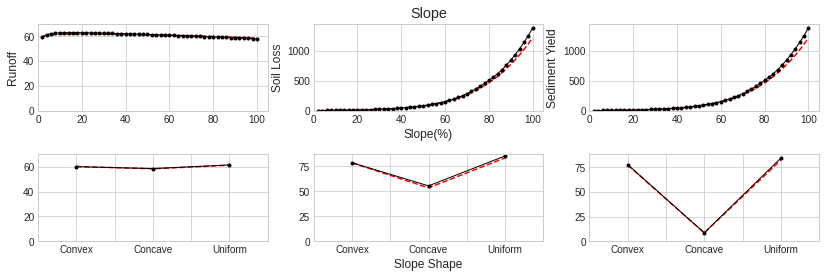

In [32]:
fig = plt.figure(figsize=(14,4))
gs = gridspec.GridSpec(2, 3, figure=fig)

plt.style.use('seaborn-whitegrid')
np.set_printoptions(suppress=True)

var_name = 'slope'
scenarios = pd.read_csv('Change_Pattern_Evaluation/{}Scenarios/{}_results_pred.csv'.format(var_name, 
                                                                           var_name)).sort_values('slope')

ax1 = fig.add_subplot(gs[0, 0])
x = scenarios.slope.values
y = scenarios.runoff.values
y1 = scenarios.pred_runoff.values

slope1, _, _, _, _ = linregress(x, y)
ax1.plot(x, y, linestyle='--', color='red', label='slope={}'.format(np.round(slope1, 3)), linewidth=1.5)
slope1, _, _, _, _ = linregress(x, y1)
ax1.plot(x, y1, marker='o', color='black', label='slope={}'.format(np.round(slope1, 3)), linewidth=1., 
         markersize=3)

ax1.set_xlim((0,None))
ax1.set_ylim((0,70))
ax1.set_ylabel('Runoff')

ax2 = fig.add_subplot(gs[0, 1])

x = scenarios.slope.values
y = scenarios.soilLoss.values
y1 = scenarios.pred_soilLoss.values

slope1, _, _, _, _ = linregress(x, y)
ax2.plot(x, y, linestyle='--', color='red', label='slope={}'.format(np.round(slope1, 3)), linewidth=1.5)
slope1, _, _, _, _ = linregress(x, y1)
ax2.plot(x, y1, marker='o', color='black', label='slope={}'.format(np.round(slope1, 3)), linewidth=1., 
         markersize=3)

ax2.set_xlim((0,None))
ax2.set_ylim((0,None))
ax2.set_xlabel('Slope(%)')
ax2.set_ylabel('Soil Loss')
ax2.set_title('Slope')

ax3 = fig.add_subplot(gs[0, 2])

x = scenarios.slope.values
y = scenarios.sedYield.values
y1 = scenarios.pred_sedYield.values

slope1, _, _, _, _ = linregress(x, y)
ax3.plot(x, y, linestyle='--', color='red', label='slope={}'.format(np.round(slope1, 3)), linewidth=1.5)
slope1, _, _, _, _ = linregress(x, y1)
ax3.plot(x, y1, marker='o', color='black', label='slope={}'.format(np.round(slope1, 3)), linewidth=1., 
         markersize=3)

ax3.set_xlim((0,None))
ax3.set_ylim((0,None))
ax3.set_ylabel('Sediment Yield')

################################

var_name = 'slopeShape'
scenarios = pd.read_csv('Change_Pattern_Evaluation/{}Scenarios/{}_results_pred.csv'.format(var_name, 
                                                                           var_name)).sort_values('RunID')

ax1 = fig.add_subplot(gs[1, 0])
x = scenarios.RunID.values
y = scenarios.runoff.values
y1 = scenarios.pred_runoff.values

slope1, _, _, _, _ = linregress(x, y)
ax1.plot(x, y, linestyle='--', color='red', label='slope={}'.format(np.round(slope1, 3)), linewidth=1.5)
slope1, _, _, _, _ = linregress(x, y1)
ax1.plot(x, y1, marker='o', color='black', label='slope={}'.format(np.round(slope1, 3)), linewidth=1., 
         markersize=3)

ax1.set_xlim((-0.5,2.5))
ax1.set_ylim((0,70))
ax1.set_xticklabels(['','Convex', '', 'Concave','', 'Uniform', ''])

ax2 = fig.add_subplot(gs[1, 1])

x = scenarios.RunID.values
y = scenarios.soilLoss.values
y1 = scenarios.pred_soilLoss.values

slope1, _, _, _, _ = linregress(x, y)
ax2.plot(x, y, linestyle='--', color='red', label='slope={}'.format(np.round(slope1, 3)), linewidth=1.5)
slope1, _, _, _, _ = linregress(x, y1)
ax2.plot(x, y1, marker='o', color='black', label='slope={}'.format(np.round(slope1, 3)), linewidth=1., 
         markersize=3)

ax2.set_xlim((-0.5,2.5))
ax2.set_ylim((0,None))
ax2.set_xlabel('Slope Shape')
ax2.set_xticklabels(['','Convex', '', 'Concave','', 'Uniform', ''])

ax3 = fig.add_subplot(gs[1, 2])

x = scenarios.RunID.values
y = scenarios.sedYield.values
y1 = scenarios.pred_sedYield.values

slope1, _, _, _, _ = linregress(x, y)
ax3.plot(x, y, linestyle='--', color='red', label='slope={}'.format(np.round(slope1, 3)), linewidth=1.5)
slope1, _, _, _, _ = linregress(x, y1)
ax3.plot(x, y1, marker='o', color='black', label='slope={}'.format(np.round(slope1, 3)), linewidth=1., 
         markersize=3)

ax3.set_xlim((-0.5,2.5))
ax3.set_ylim((0,None))
ax3.set_xticklabels(['','Convex', '', 'Concave','', 'Uniform', ''])
plt.subplots_adjust(hspace=0.5)

- For the Soil variable:

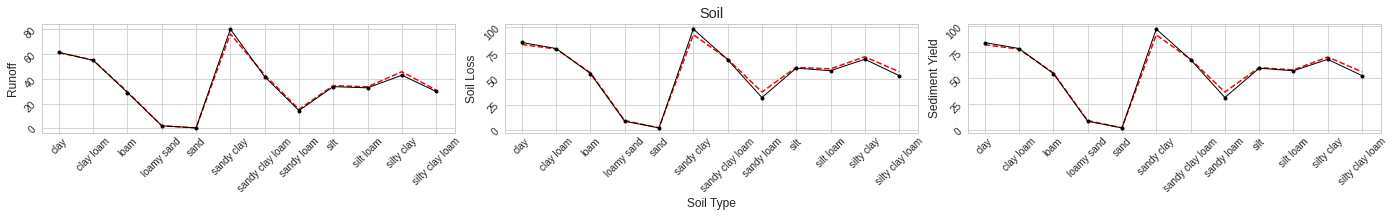

In [33]:
fig = plt.figure(figsize=(24,2))
gs = gridspec.GridSpec(1, 3, figure=fig)

plt.style.use('seaborn-whitegrid')
np.set_printoptions(suppress=True)

var_name = 'soil'
scenarios = pd.read_csv('Change_Pattern_Evaluation/{}Scenarios/{}_results_pred.csv'.format(var_name, 
                                                                           var_name)).sort_values('soil')

ax1 = fig.add_subplot(gs[0, 0])
x = scenarios.soil.values
y = scenarios.runoff.values
y1 = scenarios.pred_runoff.values

ax1.plot(x, y, linestyle='--', color='red', label='slope={}'.format(np.round(slope1, 3)), linewidth=1.5)
ax1.plot(x, y1, marker='o', color='black', label='slope={}'.format(np.round(slope1, 3)), linewidth=1., 
         markersize=3)

ax1.set_xlim((-0.5,None))
ax1.set_ylabel('Runoff')
ax1.tick_params(labelrotation=45)

ax2 = fig.add_subplot(gs[0, 1])

x = scenarios.soil.values
y = scenarios.soilLoss.values
y1 = scenarios.pred_soilLoss.values

ax2.plot(x, y, linestyle='--', color='red', label='slope={}'.format(np.round(slope1, 3)), linewidth=1.5)
ax2.plot(x, y1, marker='o', color='black', label='slope={}'.format(np.round(slope1, 3)), linewidth=1., 
         markersize=3)

ax2.set_xlim((-0.5,None))
ax2.set_xlabel('Soil Type')
ax2.set_ylabel('Soil Loss')
ax2.set_title('Soil')
ax2.tick_params(labelrotation=45)

ax3 = fig.add_subplot(gs[0, 2])

x = scenarios.soil.values
y = scenarios.sedYield.values
y1 = scenarios.pred_sedYield.values

ax3.plot(x, y, linestyle='--', color='red', label='slope={}'.format(np.round(slope1, 3)), linewidth=1.5)
ax3.plot(x, y1, marker='o', color='black', label='slope={}'.format(np.round(slope1, 3)), linewidth=1., 
         markersize=3)

ax3.set_xlim((-0.5,None))
ax3.set_ylabel('Sediment Yield')
ax3.tick_params(labelrotation=45)

plt.subplots_adjust(wspace=0.12)

### The dynamic prediction behavior of the Emulator vs. the RHEM (Section 4.6 of the paper, Figure 7)
For the next Emulator evaluation test, We are going to find out if the difference between the outputs of the Emulator in time t1 and t2 for a specific location is statistically equal to the difference of the RHEM outputs. We test it with the points in NRI dataset that has been surveyed twice with at least 5 years gap.

In [34]:
## Load the array that contains the difference between the RHEM outputs of 2 survey dates and the 
## same difference values for the Emulator. 
diffNRI = np.load('Files/Data/diffNRI.npz',allow_pickle=True, mmap_mode='r')['arr_0'].astype('float32')
print('The shape of the array is:', diffNRI.shape)
print(' ')
## The shape of the array is (2692, 6). 2,692 rows is the number of 
## NRI locations which has been surveyed twice with 5 years gap. 

## 6 columns are:
## RHEM_runoff(t2) - RHEM_runoff(t1),
## Emulator_runoff(t2) - Emulator_runoff(t1),
## RHEM_soilLoss(t2) - RHEM_soilLoss(t1),
## Emulator_sedimentYield(t2) - Emulator_sedimentYield(t1), 
## RHEM_sedimentYield(t2) - RHEM_sedimentYield(t1),
## Emulator_sedimentYield(t2) - Emulator_sedimentYield(t1)


## Perform the tests
print('Runoff Tests')
data1 = diffNRI[:,0]
data2 = diffNRI[:,1]
test1 = pearsonr(data1, data2)
print('Pearson r test:', np.round(test1[0], 2), ',   P Value:', np.round(test1[1], 2))
test2 = ttest_ind(data1, data2, equal_var=True)
print('t test:', np.round(test2[0], 2), ',   P Value:', np.round(test2[1], 2))

print(' ')

print('Soil loss Tests')
data1 = diffNRI[:,2]
data2 = diffNRI[:,3]
test1 = pearsonr(data1, data2)
print('Pearson r test:', np.round(test1[0], 2), ',   P Value:', np.round(test1[1], 2))
test2 = ttest_ind(data1, data2, equal_var=True)
print('t test:', np.round(test2[0], 2), ',   P Value:', np.round(test2[1], 2))

print(' ')

print('Sediment Yield Tests')
data1 = diffNRI[:,4]
data2 = diffNRI[:,5]
test1 = pearsonr(data1, data2)
print('Pearson r test:', np.round(test1[0], 2), ',   P Value:', np.round(test1[1], 2))
test2 = ttest_ind(data1, data2, equal_var=True)
print('t test:', np.round(test2[0], 2), ',   P Value:', np.round(test2[1], 2))

The shape of the array is: (2692, 6)
 
Runoff Tests
Pearson r test: 0.99 ,   P Value: 0.0
t test: -0.13 ,   P Value: 0.9
 
Soil loss Tests
Pearson r test: 1.0 ,   P Value: 0.0
t test: -0.07 ,   P Value: 0.94
 
Sediment Yield Tests
Pearson r test: 0.99 ,   P Value: 0.0
t test: -0.21 ,   P Value: 0.84


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica


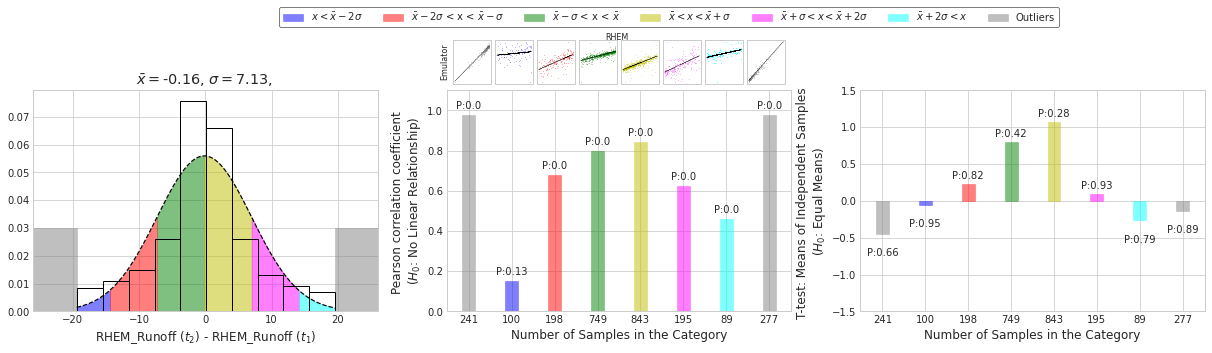

In [35]:
plt.style.use('seaborn-whitegrid')
plt.rcParams['axes.facecolor']='white'
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Helvetica'

fig = plt.figure(figsize=(21,5))
gs_outer = gridspec.GridSpec(2, 1, height_ratios = [1, 5])
gs = gridspec.GridSpecFromSubplotSpec(1, 3, subplot_spec = gs_outer[1], wspace=0.2)
gs1 = gridspec.GridSpecFromSubplotSpec(1, 28, subplot_spec = gs_outer[0], wspace=0.1)

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[0, 2])

data1 = diffNRI[:,0]
data1 = data1[(data1<19.56451)&(data1>-19.42125)]

ax1.hist(data1, 10, density=True, facecolor='none', edgecolor='black', linewidth=1)
xmin, xmax = (-19.42125,19.56451)
ax1.set_xlim((-26, 26))
ax1.set_xlabel('RHEM_Runoff ($t_2$) - RHEM_Runoff ($t_1$)')

mu, std = norm.fit(data1)
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
ax1.plot(x, p, 'black', linewidth=1.2, linestyle='--')
ax1.set_title(r'$\bar{x}=$'+'{:0.2f}, '.format(mu) + r'$\sigma=$'+'{:0.2f}, '.format(std))

out1 = np.linspace(-26, np.min(data1), 2)
out1y = np.ones_like(out1)*0.03
ax1.fill_between(out1, out1y, 0, alpha=0.5, color='grey')

p1 = norm.pdf(np.linspace(xmin, mu-2*std, 100), mu, std)
ax1.fill_between(np.linspace(xmin, mu-2*std, 100),p1,0, alpha=0.5, color='blue', 
                 label=r'$x < \bar{x} - 2\sigma$')

p1 = norm.pdf(np.linspace(mu-2*std, mu-std, 100), mu, std)
ax1.fill_between(np.linspace(mu-2*std, mu-std, 100),p1,0, alpha=0.5, color='red', 
                 label=r'$\bar{x} - 2\sigma$ < x < $\bar{x} - \sigma$')

p1 = norm.pdf(np.linspace(mu-std, mu, 100), mu, std)
ax1.fill_between(np.linspace(mu-std, mu, 100),p1,0, alpha=0.5, color='green', 
                 label=r'$\bar{x} - \sigma$ < x < $\bar{x}$')

p1 = norm.pdf(np.linspace(mu, mu+std, 100), mu, std)
ax1.fill_between(np.linspace(mu, mu+std, 100),p1,0, alpha=0.5, color='y', 
                 label=r'$\bar{x} < x < \bar{x} + \sigma$')

p1 = norm.pdf(np.linspace(mu+std, mu+2*std, 100), mu, std)
ax1.fill_between(np.linspace(mu+std, mu+2*std, 100),p1,0, alpha=0.5, color='magenta', 
                 label=r'$\bar{x} + \sigma < x < \bar{x} + 2\sigma$')

p1 = norm.pdf(np.linspace(mu+2*std, xmax, 100), mu, std)
ax1.fill_between(np.linspace(mu+2*std, xmax, 100),p1,0, alpha=0.5, color='cyan', 
                 label=r'$\bar{x} + 2\sigma < x$')

out1 = np.linspace(np.max(data1), 26, 2)
out1y = np.ones_like(out1)*0.03
ax1.fill_between(out1, out1y, 0, alpha=0.5, color='grey', label='Outliers')

legend = ax1.legend(frameon = 1, bbox_to_anchor=(0.7, 1.4), loc='upper left', ncol=7)
frame = legend.get_frame()
frame.set_facecolor('white')
frame.set_edgecolor('black')
frame.set_alpha(None)

##########################################################

sampleSize = []
pearsonTest = []
t_test = []
p_val = []
p_val_t = []

indices1 = np.where(diffNRI[:,0] <= -19.42125)
data1 = diffNRI[:,0][indices1]
data2 = diffNRI[:,1][indices1]

ax4 = fig.add_subplot(gs1[0, 10:11])
ax4.scatter(data1, data2, alpha=0.5, color='grey',s=0.1)
ax4.set_xticks([])
ax4.set_yticks([])
slope, intercept, _, _, _ = linregress(data1, data2)
ax4.plot(data1, slope*data1 + intercept, color='black', linewidth=0.2)
ax4.set_ylabel('Emulator',fontsize=8)

sampleSize.append(str(data1.size))
test1 = pearsonr(data1, data2)
pearsonTest.append(test1[0])
p_val.append(test1[1])
test2 = ttest_ind(data1, data2, equal_var=True)
t_test.append(test2[0])
p_val_t.append(test2[1])

indices1 = np.where((xmin < diffNRI[:,0]) & (diffNRI[:,0] < mu-2*std))
data1 = diffNRI[:,0][indices1]
data2 = diffNRI[:,1][indices1]

ax5 = fig.add_subplot(gs1[0, 11:12])
ax5.scatter(data1, data2, alpha=0.5, color='blue',s=0.1)
ax5.set_xticks([])
ax5.set_yticks([])
slope, intercept, _, _, _ = linregress(data1, data2)
ax5.plot(data1, slope*data1 + intercept, color='black', linewidth=0.2)

sampleSize.append(str(data1.size))
test1 = pearsonr(data1, data2)
pearsonTest.append(test1[0])
p_val.append(test1[1])
test2 = ttest_ind(data1, data2, equal_var=True)
t_test.append(test2[0])
p_val_t.append(test2[1])

indices1 = np.where((diffNRI[:,0] >= mu-2*std)&(diffNRI[:,0] < mu-std))
data1 = diffNRI[:,0][indices1]
data2 = diffNRI[:,1][indices1]

ax6 = fig.add_subplot(gs1[0, 12:13])
ax6.scatter(data1, data2, alpha=0.5, color='red',s=0.1)
ax6.set_xticks([])
ax6.set_yticks([])
slope, intercept, _, _, _ = linregress(data1, data2)
ax6.plot(data1, slope*data1 + intercept, color='black', linewidth=0.3)

sampleSize.append(str(data1.size))
test1 = pearsonr(data1, data2)
pearsonTest.append(test1[0])
p_val.append(test1[1])
test2 = ttest_ind(data1, data2, equal_var=True)
t_test.append(test2[0])
p_val_t.append(test2[1])

indices1 = np.where((diffNRI[:,0] >= mu-std)&(diffNRI[:,0] < mu))
data1 = diffNRI[:,0][indices1]
data2 = diffNRI[:,1][indices1]

ax7 = fig.add_subplot(gs1[0, 13:14])
ax7.scatter(data1, data2, alpha=0.5, color='green',s=0.1)
ax7.set_xticks([])
ax7.set_yticks([])
slope, intercept, _, _, _ = linregress(data1, data2)
ax7.plot(data1, slope*data1 + intercept, color='black', linewidth=0.3)

y_min, y_max = ax7.get_ylim()
x_min, x_max = ax7.get_xlim()
ax7.text(x= x_max / 2, y=y_max + 0.2, s='RHEM', ha='center', fontsize=8)

sampleSize.append(str(data1.size))
test1 = pearsonr(data1, data2)
pearsonTest.append(test1[0])
p_val.append(test1[1])
test2 = ttest_ind(data1, data2, equal_var=True)
t_test.append(test2[0])
p_val_t.append(test2[1])

indices1 = np.where((diffNRI[:,0] >= mu)&(diffNRI[:,0] < mu+std))
data1 = diffNRI[:,0][indices1]
data2 = diffNRI[:,1][indices1]

ax8 = fig.add_subplot(gs1[0, 14:15])
ax8.scatter(data1, data2, alpha=0.5, color='y',s=0.1)
ax8.set_xticks([])
ax8.set_yticks([])
slope, intercept, _, _, _ = linregress(data1, data2)
ax8.plot(data1, slope*data1 + intercept, color='black', linewidth=0.3)

sampleSize.append(str(data1.size))
test1 = pearsonr(data1, data2)
pearsonTest.append(test1[0])
p_val.append(test1[1])
test2 = ttest_ind(data1, data2, equal_var=True)
t_test.append(test2[0])
p_val_t.append(test2[1])

indices1 = np.where((diffNRI[:,0] >= mu+std)&(diffNRI[:,0] < mu+2*std))
data1 = diffNRI[:,0][indices1]
data2 = diffNRI[:,1][indices1]

ax9 = fig.add_subplot(gs1[0, 15:16])
ax9.scatter(data1, data2, alpha=0.5, color='magenta',s=0.1)
ax9.set_xticks([])
ax9.set_yticks([])
slope, intercept, _, _, _ = linregress(data1, data2)
ax9.plot(data1, slope*data1 + intercept, color='black', linewidth=0.3)

sampleSize.append(str(data1.size))
test1 = pearsonr(data1, data2)
pearsonTest.append(test1[0])
p_val.append(test1[1])
test2 = ttest_ind(data1, data2, equal_var=True)
t_test.append(test2[0])
p_val_t.append(test2[1])

indices1 = np.where((diffNRI[:,0] >= mu+2*std) & (diffNRI[:,0] < xmax))
data1 = diffNRI[:,0][indices1]
data2 = diffNRI[:,1][indices1]

ax10 = fig.add_subplot(gs1[0, 16:17])
ax10.scatter(data1, data2, alpha=0.5, color='cyan',s=0.5)
ax10.set_xticks([])
ax10.set_yticks([])
slope, intercept, _, _, _ = linregress(data1, data2)
ax10.plot(data1, slope*data1 + intercept, color='black', linewidth=0.3)

sampleSize.append(str(data1.size))
test1 = pearsonr(data1, data2)
pearsonTest.append(test1[0])
p_val.append(test1[1])
test2 = ttest_ind(data1, data2, equal_var=True)
t_test.append(test2[0])
p_val_t.append(test2[1])

indices1 = np.where(diffNRI[:,0] >= 19.56451)
data1 = diffNRI[:,0][indices1]
data2 = diffNRI[:,1][indices1]

ax11 = fig.add_subplot(gs1[0, 17:18])
ax11.scatter(data1, data2, alpha=0.5, color='grey',s=0.1)
ax11.set_xticks([])
ax11.set_yticks([])
slope, intercept, _, _, _ = linregress(data1, data2)
ax11.plot(data1, slope*data1 + intercept, color='black', linewidth=0.2)

sampleSize.append(str(data1.size))
test1 = pearsonr(data1, data2)
pearsonTest.append(test1[0])
p_val.append(test1[1])
test2 = ttest_ind(data1, data2, equal_var=True)
t_test.append(test2[0])
p_val_t.append(test2[1])

barlist=ax2.bar(sampleSize, pearsonTest, alpha=0.5, width=0.3)
ax2.set_xlabel('Number of Samples in the Category')
ax2.set_ylabel('Pearson correlation coefficient \n($H_0$: No Linear Relationship)')
ax2.set_ylim((0,1.1))
barlist[0].set_color('grey')
barlist[1].set_color('blue')
barlist[2].set_color('red')
barlist[3].set_color('green')
barlist[4].set_color('y')
barlist[5].set_color('magenta')
barlist[6].set_color('cyan')
barlist[7].set_color('grey')


for index, p in enumerate(barlist):
    height = p.get_height() + 0.02
    ax2.text(x=p.get_x() + p.get_width() / 2, y=height+0.01, s='P:{}'.format(np.round(p_val[index], 2)), 
             ha='center')

#####    
barlist1=ax3.bar(sampleSize, t_test, alpha=0.5, width=0.3)
ax3.set_xlabel('Number of Samples in the Category')
ax3.set_ylabel('T-test: Means of Independent Samples \n($H_0$: Equal Means)')
ax3.set_ylim((-1.5,1.5))
barlist1[0].set_color('grey')
barlist1[1].set_color('blue')
barlist1[2].set_color('red')
barlist1[3].set_color('green')
barlist1[4].set_color('y')
barlist1[5].set_color('magenta')
barlist1[6].set_color('cyan')
barlist1[7].set_color('grey')


for index, p in enumerate(barlist1):
    height = p.get_height()
    if height >= 0:
        height += 0.07
    else:
        height += -0.3
    ax3.text(x=p.get_x() + p.get_width() / 2, y=height, s='P:{}'.format(np.round(p_val_t[index], 2)), ha='center')

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Helvetica'
font = {'size'   : 14}
plt.subplots_adjust(hspace=0.05)


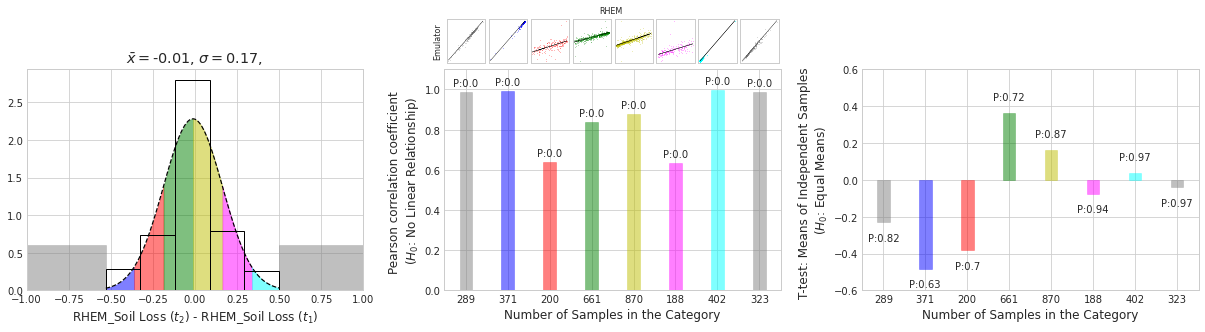

In [36]:
fig = plt.figure(figsize=(21,5))
gs_outer = gridspec.GridSpec(2, 1, height_ratios = [1, 5])
gs = gridspec.GridSpecFromSubplotSpec(1, 3, subplot_spec = gs_outer[1], wspace=0.24)
gs1 = gridspec.GridSpecFromSubplotSpec(1, 28, subplot_spec = gs_outer[0], wspace=0.1)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[0, 2])


data1 = diffNRI[:,2]
data1 = data1[(data1<=0.49904)&(data1>=-0.53015)]

ax1.hist(data1, 5, density=True, facecolor='none', edgecolor='black', linewidth=1)
ax1.set_xlim((-1,1))
ax1.set_xlabel('RHEM_Soil Loss ($t_2$) - RHEM_Soil Loss ($t_1$)')

mu, std = norm.fit(data1)
xmin, xmax = (-0.53015,0.49904)
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
ax1.plot(x, p, 'black', linewidth=1.2, linestyle='--')
ax1.set_title(r'$\bar{x}=$'+'{:0.2f}, '.format(mu) + r'$\sigma=$'+'{:0.2f}, '.format(std))

out1 = np.linspace(-1, np.min(data1), 2)
out1y = np.ones_like(out1)*0.6
ax1.fill_between(out1, out1y, 0, alpha=0.5, color='grey')

p1 = norm.pdf(np.linspace(xmin, mu-2*std, 100), mu, std)
ax1.fill_between(np.linspace(xmin, mu-2*std, 100),p1,0, alpha=0.5, color='blue', 
                 label=r'$x < \bar{x} - 2\sigma$')

p1 = norm.pdf(np.linspace(mu-2*std, mu-std, 100), mu, std)
ax1.fill_between(np.linspace(mu-2*std, mu-std, 100),p1,0, alpha=0.5, color='red', 
                 label=r'$\bar{x} - 2\sigma$ < x < $\bar{x} - \sigma$')

p1 = norm.pdf(np.linspace(mu-std, mu, 100), mu, std)
ax1.fill_between(np.linspace(mu-std, mu, 100),p1,0, alpha=0.5, color='green', 
                 label=r'$\bar{x} - \sigma$ < x < $\bar{x}$')

p1 = norm.pdf(np.linspace(mu, mu+std, 100), mu, std)
ax1.fill_between(np.linspace(mu, mu+std, 100),p1,0, alpha=0.5, color='y', 
                 label=r'$\bar{x} < x < \bar{x} + \sigma$')

p1 = norm.pdf(np.linspace(mu+std, mu+2*std, 100), mu, std)
ax1.fill_between(np.linspace(mu+std, mu+2*std, 100),p1,0, alpha=0.5, color='magenta', 
                 label=r'$\bar{x} + \sigma < x < \bar{x} + 2\sigma$')

p1 = norm.pdf(np.linspace(mu+2*std, xmax, 100), mu, std)
ax1.fill_between(np.linspace(mu+2*std, xmax, 100),p1,0, alpha=0.5, color='cyan', 
                 label=r'$\bar{x} + 2\sigma < x$')

out1 = np.linspace(np.max(data1), 1, 2)
out1y = np.ones_like(out1)*0.6
ax1.fill_between(out1, out1y, 0, alpha=0.5, color='grey', label='Outliers')


##########################################################

sampleSize = []
pearsonTest = []
t_test = []
p_val = []
p_val_t = []

indices1 = np.where(diffNRI[:,2] <= -0.53015)
data1 = diffNRI[:,0][indices1]
data2 = diffNRI[:,1][indices1]

ax4 = fig.add_subplot(gs1[0, 10:11])
ax4.scatter(data1, data2, alpha=0.5, color='grey',s=0.1)
ax4.set_xticks([])
ax4.set_yticks([])
slope, intercept, _, _, _ = linregress(data1, data2)
ax4.plot(data1, slope*data1 + intercept, color='black', linewidth=0.2)
ax4.set_ylabel('Emulator',fontsize=8)

sampleSize.append(str(data1.size))
test1 = pearsonr(data1, data2)
pearsonTest.append(test1[0])
p_val.append(test1[1])
test2 = ttest_ind(data1, data2, equal_var=True)
t_test.append(test2[0])
p_val_t.append(test2[1])

indices1 = np.where(diffNRI[:,2] < mu-2*std)
data1 = diffNRI[:,2][indices1]
data2 = diffNRI[:,3][indices1]

ax5 = fig.add_subplot(gs1[0, 11:12])
ax5.scatter(data1, data2, alpha=0.5, color='blue',s=0.1)
ax5.set_xticks([])
ax5.set_yticks([])
slope, intercept, _, _, _ = linregress(data1, data2)
ax5.plot(data1, slope*data1 + intercept, color='black', linewidth=0.2)

sampleSize.append(str(data1.size))
test1 = pearsonr(data1, data2)
pearsonTest.append(test1[0])
p_val.append(test1[1])
test2 = ttest_ind(data1, data2, equal_var=True)
t_test.append(test2[0])
p_val_t.append(test2[1])

indices1 = np.where((diffNRI[:,2] >= mu-2*std)&(diffNRI[:,2] < mu-std))
data1 = diffNRI[:,2][indices1]
data2 = diffNRI[:,3][indices1]

ax6 = fig.add_subplot(gs1[0, 12:13])
ax6.scatter(data1, data2, alpha=0.5, color='red',s=0.1)
ax6.set_xticks([])
ax6.set_yticks([])
slope, intercept, _, _, _ = linregress(data1, data2)
ax6.plot(data1, slope*data1 + intercept, color='black', linewidth=0.3)

sampleSize.append(str(data1.size))
test1 = pearsonr(data1, data2)
pearsonTest.append(test1[0])
p_val.append(test1[1])
test2 = ttest_ind(data1, data2, equal_var=True)
t_test.append(test2[0])
p_val_t.append(test2[1])

indices1 = np.where((diffNRI[:,2] >= mu-std)&(diffNRI[:,2] < mu))
data1 = diffNRI[:,2][indices1]
data2 = diffNRI[:,3][indices1]

ax7 = fig.add_subplot(gs1[0, 13:14])
ax7.scatter(data1, data2, alpha=0.5, color='green',s=0.1)
ax7.set_xticks([])
ax7.set_yticks([])
slope, intercept, _, _, _ = linregress(data1, data2)
ax7.plot(data1, slope*data1 + intercept, color='black', linewidth=0.3)

y_min, y_max = ax7.get_ylim()
x_min, x_max = ax7.get_xlim()
ax7.text(x= x_max / 2, y=y_max + 0.1, s='RHEM', ha='center', fontsize=8)

sampleSize.append(str(data1.size))
test1 = pearsonr(data1, data2)
pearsonTest.append(test1[0])
p_val.append(test1[1])
test2 = ttest_ind(data1, data2, equal_var=True)
t_test.append(test2[0])
p_val_t.append(test2[1])

indices1 = np.where((diffNRI[:,2] >= mu)&(diffNRI[:,2] < mu+std))
data1 = diffNRI[:,2][indices1]
data2 = diffNRI[:,3][indices1]

ax8 = fig.add_subplot(gs1[0, 14:15])
ax8.scatter(data1, data2, alpha=0.5, color='y',s=0.1)
ax8.set_xticks([])
ax8.set_yticks([])
slope, intercept, _, _, _ = linregress(data1, data2)
ax8.plot(data1, slope*data1 + intercept, color='black', linewidth=0.3)

sampleSize.append(str(data1.size))
test1 = pearsonr(data1, data2)
pearsonTest.append(test1[0])
p_val.append(test1[1])
test2 = ttest_ind(data1, data2, equal_var=True)
t_test.append(test2[0])
p_val_t.append(test2[1])

indices1 = np.where((diffNRI[:,2] >= mu+std)&(diffNRI[:,2] < mu+2*std))
data1 = diffNRI[:,2][indices1]
data2 = diffNRI[:,3][indices1]

ax9 = fig.add_subplot(gs1[0, 15:16])
ax9.scatter(data1, data2, alpha=0.5, color='magenta',s=0.1)
ax9.set_xticks([])
ax9.set_yticks([])
slope, intercept, _, _, _ = linregress(data1, data2)
ax9.plot(data1, slope*data1 + intercept, color='black', linewidth=0.3)

sampleSize.append(str(data1.size))
test1 = pearsonr(data1, data2)
pearsonTest.append(test1[0])
p_val.append(test1[1])
test2 = ttest_ind(data1, data2, equal_var=True)
t_test.append(test2[0])
p_val_t.append(test2[1])

indices1 = np.where(diffNRI[:,2] >= mu+2*std)
data1 = diffNRI[:,2][indices1]
data2 = diffNRI[:,3][indices1]

ax10 = fig.add_subplot(gs1[0, 16:17])
ax10.scatter(data1, data2, alpha=0.5, color='cyan',s=0.5)
ax10.set_xticks([])
ax10.set_yticks([])
slope, intercept, _, _, _ = linregress(data1, data2)
ax10.plot(data1, slope*data1 + intercept, color='black', linewidth=0.3)

sampleSize.append(str(data1.size))
test1 = pearsonr(data1, data2)
pearsonTest.append(test1[0])
p_val.append(test1[1])
test2 = ttest_ind(data1, data2, equal_var=True)
t_test.append(test2[0])
p_val_t.append(test2[1])

indices1 = np.where(diffNRI[:,2] >= 0.49904)
data1 = diffNRI[:,0][indices1]
data2 = diffNRI[:,1][indices1]

ax11 = fig.add_subplot(gs1[0, 17:18])
ax11.scatter(data1, data2, alpha=0.5, color='grey',s=0.1)
ax11.set_xticks([])
ax11.set_yticks([])
slope, intercept, _, _, _ = linregress(data1, data2)
ax11.plot(data1, slope*data1 + intercept, color='black', linewidth=0.2)

sampleSize.append(str(data1.size))
test1 = pearsonr(data1, data2)
pearsonTest.append(test1[0])
p_val.append(test1[1])
test2 = ttest_ind(data1, data2, equal_var=True)
t_test.append(test2[0])
p_val_t.append(test2[1])


barlist=ax2.bar(sampleSize, pearsonTest, alpha=0.5, width=0.3)
ax2.set_xlabel('Number of Samples in the Category')
ax2.set_ylabel('Pearson correlation coefficient \n($H_0$: No Linear Relationship)')
ax2.set_ylim((0,1.1))
barlist[0].set_color('grey')
barlist[1].set_color('blue')
barlist[2].set_color('red')
barlist[3].set_color('green')
barlist[4].set_color('y')
barlist[5].set_color('magenta')
barlist[6].set_color('cyan')
barlist[7].set_color('grey')


for index, p in enumerate(barlist):
    height = p.get_height() + 0.02
    ax2.text(x=p.get_x() + p.get_width() / 2, y=height+0.01, s='P:{}'.format(np.round(p_val[index], 2)), 
             ha='center')

#####    
barlist1=ax3.bar(sampleSize, t_test, alpha=0.5, width=0.3)
ax3.set_xlabel('Number of Samples in the Category')
ax3.set_ylabel('T-test: Means of Independent Samples \n($H_0$: Equal Means)')
ax3.set_ylim((-0.6,0.6))
barlist1[0].set_color('grey')
barlist1[1].set_color('blue')
barlist1[2].set_color('red')
barlist1[3].set_color('green')
barlist1[4].set_color('y')
barlist1[5].set_color('magenta')
barlist1[6].set_color('cyan')
barlist1[7].set_color('grey')


for index, p in enumerate(barlist1):
    height = p.get_height()
    if height >= 0:
        height += 0.07
    else:
        height += -0.1
    ax3.text(x=p.get_x() + p.get_width() / 2, y=height, s='P:{}'.format(np.round(p_val_t[index], 2)), ha='center')

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Helvetica'
font = {'size'   : 14}
plt.subplots_adjust(hspace=0.05)

/home/kia/anaconda3/envs/rhem/lib/python3.7/site-packages/ipykernel_launcher.py:236: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/kia/anaconda3/envs/rhem/lib/python3.7/site-packages/ipykernel_launcher.py:259: UserWarning: FixedFormatter should only be used together with FixedLocator


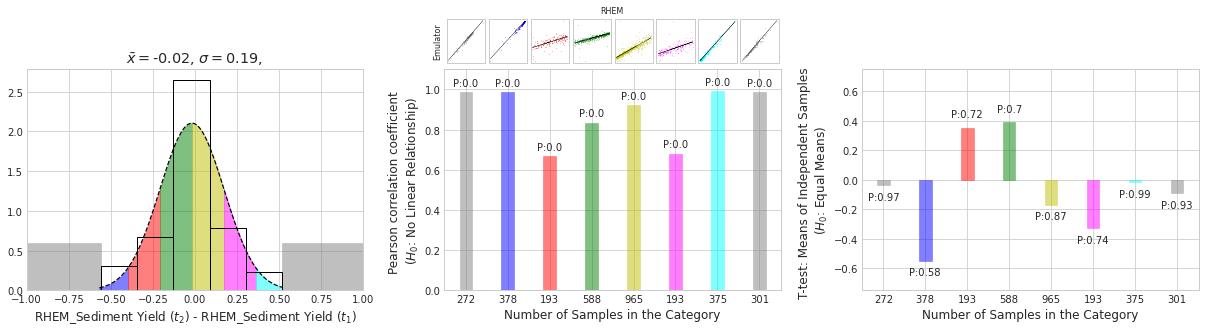

In [37]:
fig = plt.figure(figsize=(21,5))
gs_outer = gridspec.GridSpec(2, 1, height_ratios = [1, 5])
gs = gridspec.GridSpecFromSubplotSpec(1, 3, subplot_spec = gs_outer[1], wspace=0.24)
gs1 = gridspec.GridSpecFromSubplotSpec(1, 28, subplot_spec = gs_outer[0], wspace=0.1)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[0, 2])


data1 = diffNRI[:,4]
data1 = data1[(data1<=0.51914)&(data1>=-0.5681)]

ax1.hist(data1, 5, density=True, facecolor='none', edgecolor='black', linewidth=1)
ax1.set_xlim((-1,1))
ax1.set_xlabel('RHEM_Sediment Yield ($t_2$) - RHEM_Sediment Yield ($t_1$)')

mu, std = norm.fit(data1)
xmin, xmax = (-0.5681,0.51914)
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
ax1.plot(x, p, 'black', linewidth=1.2, linestyle='--')
ax1.set_title(r'$\bar{x}=$'+'{:0.2f}, '.format(mu) + r'$\sigma=$'+'{:0.2f}, '.format(std))

out1 = np.linspace(-1, np.min(data1), 2)
out1y = np.ones_like(out1)*0.6
ax1.fill_between(out1, out1y, 0, alpha=0.5, color='grey')

p1 = norm.pdf(np.linspace(xmin, mu-2*std, 100), mu, std)
ax1.fill_between(np.linspace(xmin, mu-2*std, 100),p1,0, alpha=0.5, color='blue', 
                 label=r'$x < \bar{x} - 2\sigma$')

p1 = norm.pdf(np.linspace(mu-2*std, mu-std, 100), mu, std)
ax1.fill_between(np.linspace(mu-2*std, mu-std, 100),p1,0, alpha=0.5, color='red', 
                 label=r'$\bar{x} - 2\sigma$ < x < $\bar{x} - \sigma$')

p1 = norm.pdf(np.linspace(mu-std, mu, 100), mu, std)
ax1.fill_between(np.linspace(mu-std, mu, 100),p1,0, alpha=0.5, color='green', 
                 label=r'$\bar{x} - \sigma$ < x < $\bar{x}$')

p1 = norm.pdf(np.linspace(mu, mu+std, 100), mu, std)
ax1.fill_between(np.linspace(mu, mu+std, 100),p1,0, alpha=0.5, color='y', 
                 label=r'$\bar{x} < x < \bar{x} + \sigma$')

p1 = norm.pdf(np.linspace(mu+std, mu+2*std, 100), mu, std)
ax1.fill_between(np.linspace(mu+std, mu+2*std, 100),p1,0, alpha=0.5, color='magenta', 
                 label=r'$\bar{x} + \sigma < x < \bar{x} + 2\sigma$')

p1 = norm.pdf(np.linspace(mu+2*std, xmax, 100), mu, std)
ax1.fill_between(np.linspace(mu+2*std, xmax, 100),p1,0, alpha=0.5, color='cyan', 
                 label=r'$\bar{x} + 2\sigma < x$')

out1 = np.linspace(np.max(data1), 1, 2)
out1y = np.ones_like(out1)*0.6
ax1.fill_between(out1, out1y, 0, alpha=0.5, color='grey', label='Outliers')

##########################################################

sampleSize = []
pearsonTest = []
t_test = []
p_val = []
p_val_t = []

indices1 = np.where(diffNRI[:,4] <= -0.5681)
data1 = diffNRI[:,0][indices1]
data2 = diffNRI[:,1][indices1]

ax4 = fig.add_subplot(gs1[0, 10:11])
ax4.scatter(data1, data2, alpha=0.5, color='grey',s=0.1)
ax4.set_xticks([])
ax4.set_yticks([])
slope, intercept, _, _, _ = linregress(data1, data2)
ax4.plot(data1, slope*data1 + intercept, color='black', linewidth=0.2)
ax4.set_ylabel('Emulator',fontsize=8)

sampleSize.append(str(data1.size))
test1 = pearsonr(data1, data2)
pearsonTest.append(test1[0])
p_val.append(test1[1])
test2 = ttest_ind(data1, data2, equal_var=True)
t_test.append(test2[0])
p_val_t.append(test2[1])

indices1 = np.where(diffNRI[:,4] < mu-2*std)
data1 = diffNRI[:,4][indices1]
data2 = diffNRI[:,5][indices1]

ax5 = fig.add_subplot(gs1[0, 11:12])
ax5.scatter(data1, data2, alpha=0.5, color='blue',s=0.1)
ax5.set_xticks([])
ax5.set_yticks([])
slope, intercept, _, _, _ = linregress(data1, data2)
ax5.plot(data1, slope*data1 + intercept, color='black', linewidth=0.2)

sampleSize.append(str(data1.size))
test1 = pearsonr(data1, data2)
pearsonTest.append(test1[0])
p_val.append(test1[1])
test2 = ttest_ind(data1, data2, equal_var=True)
t_test.append(test2[0])
p_val_t.append(test2[1])

indices1 = np.where((diffNRI[:,4] >= mu-2*std)&(diffNRI[:,4] < mu-std))
data1 = diffNRI[:,4][indices1]
data2 = diffNRI[:,5][indices1]

ax6 = fig.add_subplot(gs1[0, 12:13])
ax6.scatter(data1, data2, alpha=0.5, color='red',s=0.1)
ax6.set_xticks([])
ax6.set_yticks([])
slope, intercept, _, _, _ = linregress(data1, data2)
ax6.plot(data1, slope*data1 + intercept, color='black', linewidth=0.3)

sampleSize.append(str(data1.size))
test1 = pearsonr(data1, data2)
pearsonTest.append(test1[0])
p_val.append(test1[1])
test2 = ttest_ind(data1, data2, equal_var=True)
t_test.append(test2[0])
p_val_t.append(test2[1])

indices1 = np.where((diffNRI[:,4] >= mu-std)&(diffNRI[:,4] < mu))
data1 = diffNRI[:,4][indices1]
data2 = diffNRI[:,5][indices1]

ax7 = fig.add_subplot(gs1[0, 13:14])
ax7.scatter(data1, data2, alpha=0.5, color='green',s=0.1)
ax7.set_xticks([])
ax7.set_yticks([])
slope, intercept, _, _, _ = linregress(data1, data2)
ax7.plot(data1, slope*data1 + intercept, color='black', linewidth=0.3)

y_min, y_max = ax7.get_ylim()
x_min, x_max = ax7.get_xlim()
ax7.text(x= x_max / 2, y=y_max + 0.1, s='RHEM', ha='center', fontsize=8)

sampleSize.append(str(data1.size))
test1 = pearsonr(data1, data2)
pearsonTest.append(test1[0])
p_val.append(test1[1])
test2 = ttest_ind(data1, data2, equal_var=True)
t_test.append(test2[0])
p_val_t.append(test2[1])

indices1 = np.where((diffNRI[:,4] >= mu)&(diffNRI[:,4] < mu+std))
data1 = diffNRI[:,4][indices1]
data2 = diffNRI[:,5][indices1]

ax8 = fig.add_subplot(gs1[0, 14:15])
ax8.scatter(data1, data2, alpha=0.5, color='y',s=0.1)
ax8.set_xticks([])
ax8.set_yticks([])
slope, intercept, _, _, _ = linregress(data1, data2)
ax8.plot(data1, slope*data1 + intercept, color='black', linewidth=0.3)

sampleSize.append(str(data1.size))
test1 = pearsonr(data1, data2)
pearsonTest.append(test1[0])
p_val.append(test1[1])
test2 = ttest_ind(data1, data2, equal_var=True)
t_test.append(test2[0])
p_val_t.append(test2[1])

indices1 = np.where((diffNRI[:,4] >= mu+std)&(diffNRI[:,4] < mu+2*std))
data1 = diffNRI[:,4][indices1]
data2 = diffNRI[:,5][indices1]

ax9 = fig.add_subplot(gs1[0, 15:16])
ax9.scatter(data1, data2, alpha=0.5, color='magenta',s=0.1)
ax9.set_xticks([])
ax9.set_yticks([])
slope, intercept, _, _, _ = linregress(data1, data2)
ax9.plot(data1, slope*data1 + intercept, color='black', linewidth=0.3)

sampleSize.append(str(data1.size))
test1 = pearsonr(data1, data2)
pearsonTest.append(test1[0])
p_val.append(test1[1])
test2 = ttest_ind(data1, data2, equal_var=True)
t_test.append(test2[0])
p_val_t.append(test2[1])

indices1 = np.where(diffNRI[:,4] >= mu+2*std)
data1 = diffNRI[:,4][indices1]
data2 = diffNRI[:,5][indices1]

ax10 = fig.add_subplot(gs1[0, 16:17])
ax10.scatter(data1, data2, alpha=0.5, color='cyan',s=0.5)
ax10.set_xticks([])
ax10.set_yticks([])
slope, intercept, _, _, _ = linregress(data1, data2)
ax10.plot(data1, slope*data1 + intercept, color='black', linewidth=0.3)

sampleSize.append(str(data1.size))
test1 = pearsonr(data1, data2)
pearsonTest.append(test1[0])
p_val.append(test1[1])
test2 = ttest_ind(data1, data2, equal_var=True)
t_test.append(test2[0])
p_val_t.append(test2[1])

indices1 = np.where(diffNRI[:,4] >= 0.51914)
data1 = diffNRI[:,0][indices1]
data2 = diffNRI[:,1][indices1]

ax11 = fig.add_subplot(gs1[0, 17:18])
ax11.scatter(data1, data2, alpha=0.5, color='grey',s=0.1)
ax11.set_xticks([])
ax11.set_yticks([])
slope, intercept, _, _, _ = linregress(data1, data2)
ax11.plot(data1, slope*data1 + intercept, color='black', linewidth=0.2)

sampleSize.append(str(data1.size))
test1 = pearsonr(data1, data2)
pearsonTest.append(test1[0])
p_val.append(test1[1])
test2 = ttest_ind(data1, data2, equal_var=True)
t_test.append(test2[0])
p_val_t.append(test2[1])

sampleSize[2]='194'
barlist=ax2.bar(sampleSize, pearsonTest, alpha=0.5, width=0.3)
ax2.set_xlabel('Number of Samples in the Category')
ax2.set_ylabel('Pearson correlation coefficient \n($H_0$: No Linear Relationship)')
ax2.set_ylim((0,1.1))
barlist[0].set_color('grey')
barlist[1].set_color('blue')
barlist[2].set_color('red')
barlist[3].set_color('green')
barlist[4].set_color('y')
barlist[5].set_color('magenta')
barlist[6].set_color('cyan')
barlist[7].set_color('grey')

sampleSize[2]='193'
ax2.set_xticklabels(sampleSize)

for index, p in enumerate(barlist):
    height = p.get_height()+0.02
    ax2.text(x=p.get_x() + p.get_width() / 2, y=height+0.01, s='P:{}'.format(np.round(p_val[index], 2)), 
             ha='center')

#####    
sampleSize[2]='194'
barlist1=ax3.bar(sampleSize, t_test, alpha=0.5, width=0.3)
ax3.set_xlabel('Number of Samples in the Category')
ax3.set_ylabel('T-test: Means of Independent Samples \n($H_0$: Equal Means)')
ax3.set_ylim((-0.75,0.75))
barlist1[0].set_color('grey')
barlist1[1].set_color('blue')
barlist1[2].set_color('red')
barlist1[3].set_color('green')
barlist1[4].set_color('y')
barlist1[5].set_color('magenta')
barlist1[6].set_color('cyan')
barlist1[7].set_color('grey')

sampleSize[2]='193'
ax3.set_xticklabels(sampleSize)

for index, p in enumerate(barlist1):
    height = p.get_height()
    if height >= 0:
        height += 0.07
    else:
        height += -0.1
    ax3.text(x=p.get_x() + p.get_width() / 2, y=height, s='P:{}'.format(np.round(p_val_t[index], 2)), ha='center')

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Helvetica'
font = {'size'   : 14}
plt.subplots_adjust(hspace=0.05)
